In [1]:
import numpy as np
import pandas as p
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib
# from adjustText import adjust_text
from Bio import SeqIO
from Bio.Seq import Seq
from matplotlib import gridspec
from matplotlib.gridspec import GridSpec
# %matplotlib notebook
%matplotlib inline

from scipy.spatial import distance

from ast import literal_eval

import gzip
from cyvcf2 import VCF

import os
import sys

tools_path = '../code/tools.py'
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools as tools

from itertools import combinations

sns.set_style('white')
sns.set_style('ticks')
sns.set_color_codes()

ModuleNotFoundError: No module named 'tools'

In [2]:
snps = p.read_csv('EvolvingFront_WGS_SNPs_by_sample.csv')

In [3]:
gene_hits = {}

for info in snps['all_information'].values:
    genes_found_here = []
    for mutation in info.split('~'):
    
        if len(mutation.split(':')) == 9:
            (chrom,pos,ref,alt,gene,effect,hgvs_c,hgvs_p,call) =  mutation.split(':')
            if gene not in genes_found_here:
                if gene not in gene_hits:
                    gene_hits[gene] = [f'{effect}:{hgvs_c}:{hgvs_p}:{call}']
                elif f'{effect}:{hgvs_c}:{hgvs_p}:{call}' not in gene_hits[gene]:
                    gene_hits[gene].append(f'{effect}:{hgvs_c}:{hgvs_p}:{call}')
                genes_found_here.append(gene)

gene_hit_count = {gene:len(effects) for gene,effects in gene_hits.items()}

gene_hit_df = p.DataFrame(columns=['gene','count','effects'])
gene_hit_df['gene'] = gene_hit_count.keys()
gene_hit_df['count'] = gene_hit_count.values()
gene_hit_df['effects'] = gene_hits.values()

In [4]:
gene_hit_df.sort_values('count',ascending=False).to_csv('EvolvingFront_WGS_RepeatHitGenes.csv')

In [5]:
gene_hit_df.sort_values('count',ascending=False)

,gene,count,effects
5,KSP1,68,"[frameshift_variant:c.1529delT:p.Phe510fs:1/1,..."
110,PUF3,28,"[stop_gained:c.1519C>T:p.Gln507*:1/1, stop_gai..."
104,RTG2,15,"[missense_variant:c.989G>T:p.Ser330Ile:1/1, mi..."
161,PAB1,13,"[missense_variant:c.127G>C:p.Gly43Arg:1/1, mis..."
109,CIT1,13,"[missense_variant:c.1307G>T:p.Gly436Val:1/1, m..."
...,...,...,...
165,YNK1,1,[upstream_gene_variant:c.-1469A>T:nan:1/1]
164,tV(AAC)G2,1,[synonymous_variant:c.54G>A:p.Gln18Gln:1/1]
163,CWH43,1,[missense_variant:c.1765G>A:p.Val589Ile:1/1]
159,RQC2,1,[missense_variant:c.2251G>A:p.Glu751Lys:0/1]


In [6]:
genes_sorted = np.asarray(list(gene_hit_count.keys()))[np.argsort(list(gene_hit_count.values()))[::-1]]

In [7]:
ancestral_mutations = {'IRA1_NON':'II:522427:A:T:IRA1:stop_gained:c.4202T>A:p.Leu1401*:1/1',
                      'IRA1_MIS':'II:522697:G:A:IRA1:missense_variant:c.3932C>T:p.Ala1311Val:1/1',
                      'CYR1':'X:427906:C:A:CYR1:missense_variant:c.2750C>A:p.Ser917Tyr:1/1',
                      'GPB2':'I:40104:T:G:GPB2:stop_gained:c.846T>G:p.Tyr282*:1/1',
                      'TOR1':'X:564551:T:G:TOR1:missense_variant:c.5136T>G:p.Phe1712Leu:1/1'}

ancestral_mutations_map = {value:key for key,value in ancestral_mutations.items()}

ancestors = []

for all_information in snps['all_information'].values:
    mutation_list = all_information.split('~')
    ancestor = np.nan
    for mutation in mutation_list:
        if mutation in ancestral_mutations_map.keys():
            if not p.isnull(ancestor):
                print(f'uh oh - both {ancestor} and {ancestral_mutations_map[mutation]  }')
                ancestor = ancestral_mutations_map[mutation]                
            else:
                ancestor = ancestral_mutations_map[mutation]
    ancestors.append(ancestor)
    
snps['ancestor'] = ancestors
    

In [8]:
ancestral_mutations

{'IRA1_NON': 'II:522427:A:T:IRA1:stop_gained:c.4202T>A:p.Leu1401*:1/1',
 'IRA1_MIS': 'II:522697:G:A:IRA1:missense_variant:c.3932C>T:p.Ala1311Val:1/1',
 'CYR1': 'X:427906:C:A:CYR1:missense_variant:c.2750C>A:p.Ser917Tyr:1/1',
 'GPB2': 'I:40104:T:G:GPB2:stop_gained:c.846T>G:p.Tyr282*:1/1',
 'TOR1': 'X:564551:T:G:TOR1:missense_variant:c.5136T>G:p.Phe1712Leu:1/1'}

In [9]:
snps['all_information'].values[0]

'II:522427:A:T:IRA1:stop_gained:c.4202T>A:p.Leu1401*:1/1~II:627467:G:T:MCM7:missense_variant:c.1696G>T:p.Ala566Ser:1/1~VI:101127:T:A:YFL021C-A:upstream_gene_variant:c.-4512A>T:nan:1/1~VI:211578:C:A:PTR3:missense_variant:c.642C>A:p.Asn214Lys:1/1~VII:161471:G:C:ATG1:missense_variant:c.1407G>C:p.Leu469Phe:1/1~VIII:270019:GA:G:KSP1:frameshift_variant:c.1529delT:p.Phe510fs:1/1~XII:1029498:C:A:RPL6B:synonymous_variant:c.261C>A:p.Thr87Thr:1/1~XIV:204739:G:A:KEX2:missense_variant:c.2312G>A:p.Ser771Asn:1/1~XVI:689666:T:TA:SPE3:upstream_gene_variant:c.-4230_-4229insT:nan:1/1'

In [10]:
preexisting_mutations  = {}
preexisting_mutations_genes = {}

for ancestor in ancestral_mutations.keys():
    this_anc = snps[snps['ancestor']==ancestor]
    
    
    
    all_mutations = []
    for info in this_anc['all_information'].values:
        all_mutations += list(info.split('~'))
        
    muts,counts = np.unique(all_mutations,return_counts=True)
    pre_ix = np.where(counts>4)[0]
    
    
    preexisting_mutations[ancestor] = [mut for mut in muts[pre_ix] if ':' in mut]
    preexisting_mutations_genes[ancestor] = []
    for m,mut in enumerate(muts[pre_ix]):
        if ':' in mut:
            split = mut.split(':')
            preexisting_mutations_genes[ancestor].append(f'{split[4]}:{split[5]}({counts[pre_ix][m]})')
            
preexisting_mutations_genes['WT'] = []
preexisting_mutations['WT'] = []

In [11]:
muts[pre_ix]
counts[pre_ix]

array([14, 14, 21, 21,  5])

In [12]:
preexisting_mutations_genes

{'IRA1_NON': ['IRA1:stop_gained(129)',
  'PAB1:missense_variant(12)',
  'YFL021C-A:upstream_gene_variant(128)',
  'YGR266W:missense_variant(6)',
  'ATG1:missense_variant(39)',
  'RPL6B:synonymous_variant(126)',
  'PUF3:frameshift_variant(5)',
  'KEX2:missense_variant(40)',
  'ELA1:synonymous_variant(11)',
  'SPP2:missense_variant(77)'],
 'IRA1_MIS': ['IRA1:missense_variant(150)',
  'MIT1:disruptive_inframe_deletion(5)',
  'YKL050C:upstream_gene_variant(14)',
  'MDH2:upstream_gene_variant(47)'],
 'CYR1': ['MED8:upstream_gene_variant(33)',
  'CYR1:missense_variant(35)',
  'UBR2:upstream_gene_variant(13)',
  'ARR3:missense_variant(35)'],
 'GPB2': ['GPB2:stop_gained(22)',
  'PAL1:missense_variant(5)',
  'YFL021C-A:upstream_gene_variant(21)',
  'ACT1:upstream_gene_variant(7)'],
 'TOR1': ['YGR235C:missense_variant(14)',
  'tF(GAA)H2:upstream_gene_variant(14)',
  'TOR1:missense_variant(21)',
  'MRPL10:missense_variant(21)',
  'COG6:upstream_gene_variant(5)'],
 'WT': []}

In [13]:
gene_hits = {}
gene_hits_samples = {}
gene_hit_count = {}

for ancestor in ancestral_mutations.keys():
    this_anc = snps[snps['ancestor']==ancestor]
    
    gene_hits[ancestor] = {}
    gene_hits_samples[ancestor] = {}
    
    for sample,info in zip(this_anc['sample'].values,this_anc['all_information'].values):
        genes_in_sample = []
        for mutation in info.split('~'):
            if len(mutation.split(':')) == 9:
                (chrom,pos,ref,alt,gene,effect,hgvs_c,hgvs_p,call) =  mutation.split(':')
                if mutation != ancestral_mutations[ancestor]:
                    if gene not in genes_in_sample:
                        if gene not in gene_hits[ancestor]:
                            gene_hits[ancestor][gene] = [f'{effect}:{hgvs_c}:{hgvs_p}:{call}']
                            gene_hits_samples[ancestor][gene] = [sample]
                        else:
                            if f'{effect}:{hgvs_c}:{hgvs_p}:{call}' not in gene_hits[ancestor][gene]:
                                gene_hits[ancestor][gene].append(f'{effect}:{hgvs_c}:{hgvs_p}:{call}')
                                gene_hits_samples[ancestor][gene].append(sample)
                        genes_in_sample.append(gene)

    gene_hit_count[ancestor] = {gene:len(effects) for gene,effects in gene_hits[ancestor].items()}

    
gene_hit_anc_df = p.DataFrame(columns=['ancestor','gene','count','effects','samples'])

gene_list = []
count_list = []
effect_list = []
anc_list = []
sample_list = []

for ancestor in ancestral_mutations.keys():
    gene_list += gene_hit_count[ancestor].keys()
    count_list += (gene_hit_count[ancestor].values())
    effect_list += gene_hits[ancestor].values()
    anc_list += [ancestor] * len(gene_hit_count[ancestor].keys())
    sample_list += gene_hits_samples[ancestor].values()

gene_hit_anc_df['ancestor'] = anc_list
gene_hit_anc_df['gene'] = gene_list
gene_hit_anc_df['count'] =  count_list
gene_hit_anc_df['effects'] = effect_list
gene_hit_anc_df['samples'] = sample_list

In [14]:
gene_hit_anc_df.to_csv('EvolvingFront_WGS_RepeatHitGenes_byAncestor.csv')

In [15]:
all_ancs = gene_hit_anc_df.groupby('gene',as_index=False).sum()

sorted_all = all_ancs[all_ancs['count']>1].sort_values(['count','gene'],ascending=[False,True])
# sorted_all = all_ancs.sort_values(['count','gene'],ascending=[False,True])

count_matrix = np.zeros((len(ancestral_mutations.keys())+1,len(sorted_all)))

count_matrix[0,:] = sorted_all['count'].values

for a,ancestor in enumerate(ancestral_mutations.keys()):
    for g,gene in enumerate(sorted_all['gene'].values):
        this_gene_anc = gene_hit_anc_df[(gene_hit_anc_df['gene']==gene) & (gene_hit_anc_df['ancestor']==ancestor)]
        if len(this_gene_anc) == 1:
            count_matrix[a+1,g] = this_gene_anc['count'].values[0]


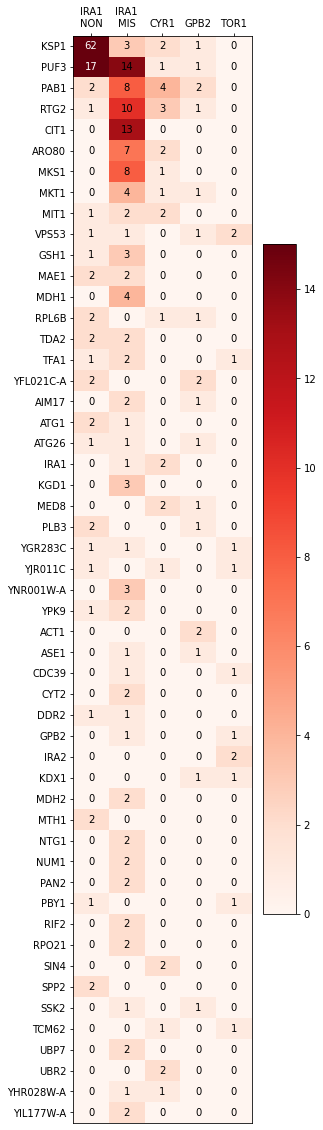

In [16]:
plt.figure(figsize=(4,20))
plt.pcolormesh(count_matrix[1:,:].swapaxes(0,1),cmap='Reds',vmin=0,vmax=15)
plt.colorbar()
# plt.cmap()
# plt.yticks([x+0.5 for x in range(len(ancestral_mutations.keys())+1)],['All']+list(ancestral_mutations.keys()))
plt.xticks([x+0.5 for x in range(len(ancestral_mutations.keys()))],[item.replace('_','\n') for item in list(ancestral_mutations.keys())])
plt.yticks([x+0.5 for x in range(len(sorted_all['gene'].values))],list(sorted_all['gene'].values))

for a in range(len(ancestral_mutations.keys())):
    for g in range(len(sorted_all['gene'].values)):
        text_color='k'
        if count_matrix[a+1,g] > 15:
            text_color = 'w'
        
        plt.text(x=a+0.5,y=g+0.5,s=f'{int(count_matrix[a+1,g])}',ha='center',va='center',color=text_color)

plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()
# plt.savefig('plots/WGS_GeneHits_Matrix.pdf',bbox_inches='tight')

In [20]:
ploidy_calls = p.read_csv('../BenomylTest/EvolvingFront_rearray_map_with_ploidy.csv')
# wgs_identified_barcodes = p.read_csv('EvolvingFront_WGS_allExtractedBCs.csv')
wgs_identified_barcodes = p.read_csv('EvolvingFront_WGS_IdentifiedBarcodes.csv')
# sequencing_map = p.read_csv('sequencing_maps/EvolvingFront_Sequencing_list.csv')
sequencing_map = p.read_csv('EvolvingFront_Sequencing_list.csv')
plate5_map = p.read_csv('EvolvingFront_WGS_Plate5_map.csv')

additions = p.DataFrame([['EVO3D_TCG_rearray_Plate1-G11','EvolvingFront_Sequencing_Plate4-E11','CCGCCAATCCCGAACCCCGTTTCGCC_TATGCAAGACACAACATGCTTTTAAT'],
                                       ['EVO3D_TCG_rearray_Plate1-G12','EvolvingFront_Sequencing_Plate4-E12','GACAGAAAAGCCAAATGGATTTACCG_AGCATAATAGCTAAGAGTATTTACTA']],
                                      columns=['source_well','destination_well','barcode'])

sequencing_map = p.concat([sequencing_map,additions])

### replace sequencing samples with Plate5 instead of old name
new_dest_wells = []
for old_plate in sequencing_map['destination_well'].values:
    old_name = old_plate.replace('EvolvingFront_Sequencing_','')
    if old_name in plate5_map['oldplate_name'].values:
        new_name = plate5_map[plate5_map['oldplate_name']==old_name]['Well'].values[0]
        new_dest_wells.append(f'EvolvingFront_Sequencing_{new_name}')
        print(old_name,new_name)
    else:
        new_dest_wells.append(f'EvolvingFront_Sequencing_{old_name}')
sequencing_map['destination_well'] = new_dest_wells

print(sequencing_map['destination_well'])

dests_renamed = []
for plate in sequencing_map['destination_well'].values:
    prefix = plate.split('-')[0]
    row = plate.split('-')[1][0]
    col = plate.split('-')[1][1:]
    
#     print(prefix,row,col)
    dests_renamed.append(f"{prefix.replace('Sequencing','WGS')}_{row}{int(col):02}")
sequencing_map['destination_well_renamed'] = dests_renamed


source_names = []
intended_bcs = []
oriented_barcodes = []

files_for_removal = []

for entry,barcode in zip(wgs_identified_barcodes['file_prefix'].values,wgs_identified_barcodes['doubleBC'].values):
    
    if 'rearray' in entry:
#         source_well = 
        
        source_names.append(entry)
        intended_bcs.append(ploidy_calls[ploidy_calls['destination_well']==entry]['barcode'].values[0])
        oriented_barcodes.append(f"{barcode.split('_')[1]}_{barcode.split('_')[0]}")
    else:
        if entry in sequencing_map['destination_well_renamed'].values:
            source_well = sequencing_map[sequencing_map['destination_well_renamed']==entry]['source_well'].values[0] 
            source_names.append(source_well)

            intended_bcs.append(sequencing_map[sequencing_map['destination_well_renamed']==entry]['barcode'].values[0])
            oriented_barcodes.append(f"{barcode.split('_')[1]}_{barcode.split('_')[0]}")
        else:
            print(entry)
            files_for_removal.append(entry)
            
wgs_identified_barcodes = wgs_identified_barcodes[~wgs_identified_barcodes['file_prefix'].isin(files_for_removal)]
            
wgs_identified_barcodes['source_name'] = source_names
wgs_identified_barcodes['intendedBC'] = intended_bcs
wgs_identified_barcodes['observedBC'] = oriented_barcodes



FileNotFoundError: [Errno 2] No such file or directory: 'EvolvingFront_WGS_Plate5_map.csv'

In [36]:
wgs_identified_barcodes.to_csv('EvolvingFront_WGS_IdentifiedBarcodes.csv',index=False)

In [37]:
snps['file_prefix'] = snps['sample']

In [38]:
snps_plus_bcs = p.merge(wgs_identified_barcodes,snps,on='file_prefix')

# new column without ancestral mutations (+ call ancestral mutations??)

In [40]:
mutations_in_ancestor = {}

for ancestor in list(ancestral_mutations.keys()):
    this_anc = snps_plus_bcs[snps_plus_bcs['ancestor']==ancestor]
    
    mutations_here = []
    
    for info in this_anc['all_information'].values:
        mutations_here += info.split('~')
        
    unique_mutations,unique_counts = np.unique(mutations_here,return_counts=True)
    
    multi_muts = unique_mutations[np.where(unique_counts>1)[0]]
    multi_counts = unique_counts[np.where(unique_counts>1)[0]]
    
    for mut,count in zip(multi_muts[np.argsort(multi_counts)[::-1]],multi_counts[np.argsort(multi_counts)[::-1]]):
        print('\n')
        print(mut,count)
        for (sample,bc,mutations,info) in zip(this_anc['sample'].values,this_anc['observedBC'].values,
                                          this_anc['mutations'].values,this_anc['all_information'].values):
            if mut in info:
                print(sample,bc)
        




II:522427:A:T:IRA1:stop_gained:c.4202T>A:p.Leu1401*:1/1 126
EVO3D_IRA1_NON_rearray_Plate1-D7 _
EVO3D_IRA1_NON_rearray_Plate1-E2 ATCACAATAACTAAACTGATTCTTCA_ACTGGAAATCCCAATCAATTTGAAGG
EVO3D_IRA1_NON_rearray_Plate1-E8 ATCACAATAACTAAACTGATTCTTCA_CCTGGAAAGGGTAACACGTTTCGGAA
EVO3D_IRA1_NON_rearray_Plate2-B11 ATCACAATAACTAAACTGATTCTTCA_CGTTTAAAAACTAATCAAATTCGAGT
EVO3D_IRA1_NON_rearray_Plate2-B12 ATCACAATAACTAAACTGATTCTTCA_GAGAGAAAACCGAATGGTTTTGTCAC
EVO3D_IRA1_NON_rearray_Plate2-C3 _
EVO3D_IRA1_NON_rearray_Plate2-C10 ATCACAATAACTAAACTGATTCTTCA_GCTCTAAAAGCAAAAGGTTTTTGAGA
EvolvingFront_WGS_Plate3_A01 CCAACAAAACACAAATCTGTTGTGTA_CGCCCAATTTCCAATATCTTTAAGCT
EvolvingFront_WGS_Plate3_A02 CCAACAAAACACAAATCTGTTGTGTA_GCGAGAATTTGAAAACCACTTAATCA
EvolvingFront_WGS_Plate3_A03 CCAACAAAACACAAATCTGTTGTGTA_AGAGCAAAGGTGAATGTAGTTTAATG
EvolvingFront_WGS_Plate3_A04 CCAACAAAACACAAATCTGTTGTGTA_ACCATAAGTTTTAAAAGAGTTATTGC
EvolvingFront_WGS_Plate3_A05 CCAACAAAACACAAATCTGTTGTGTA_TACGAAAAATATAAAGGAGTTTATTT
EvolvingFront_W

VIII:269933:GA:G:KSP1:frameshift_variant:c.1615delT:p.Ser539fs:1/1 2
EvolvingFront_WGS_Plate3_G11 ATCACAATAACTAAACTGATTCTTCA_GTTTTAAGTTAGAATGGCTTTGCTCG
EvolvingFront_WGS_Plate3_H10 ATCACAATAACTAAACTGATTCTTCA_CTCTCAATGTGGAAGTATATTGCTAC


VIII:269753:G:T:KSP1:stop_gained:c.1796C>A:p.Ser599*:1/1 2
EvolvingFront_WGS_Plate3_B09 CCAACAAAACACAAATCTGTTGTGTA_CTCCTAAACTGTAAATTAGTTGACGC
EvolvingFront_WGS_Plate5_H01 CCAACAAAACACAAATCTGTTGTGTA_GTCTTAAATGGTAACACATTTCGGAA


XI:387148:GTGA:G:TFA1:disruptive_inframe_deletion:c.1419_1421delTGA:p.Asp473del:0/1 2
EvolvingFront_WGS_Plate3_A08 CCAACAAAACACAAATCTGTTGTGTA_ACCATAAAATGTAATGCGTTTCAGTG
EvolvingFront_WGS_Plate3_D07 CCAACAAAACACAAATCTGTTGTGTA_CGGTCAAGGTGTAAGATTATTTTTAA


XII:122900:AT:A:PUF3:frameshift_variant:c.1814delA:p.Asn605fs:1/1 2
EvolvingFront_WGS_Plate3_C11 CCAACAAAACACAAATCTGTTGTGTA_TAAAAAAGGTGGAAGGGTTTTCGTAC
EvolvingFront_WGS_Plate3_C12 CCAACAAAACACAAATCTGTTGTGTA_TTATGAACTCAAAAACATGTTTCTTC


XII:841888:C:A:RSC2:synonymous_variant:c.558C>

EvolvingFront_WGS_Plate4_B05 GACAGAAAAGCCAAATGGATTTACCG_ATGGGAACACGGAATGATCTTTTATT
EvolvingFront_WGS_Plate4_B07 _


I:40104:T:G:GPB2:stop_gained:c.846T>G:p.Tyr282*:1/1 22
EvolvingFront_WGS_Plate4_B06 CCAACAAAAGGAAACGTATTTATTGA_TCGACAAATTGTAAGCATATTGTCAC
EvolvingFront_WGS_Plate4_B08 CCGCCAATCCCGAACCCCGTTTCGCC_TCCCAAACAAGAAACAATATTGGCAA
EvolvingFront_WGS_Plate4_B10 CCGCCAATCCCGAACCCCGTTTCGCC_GACAAAACTAATAATTAATTTGCATA
EvolvingFront_WGS_Plate4_C03 _
EvolvingFront_WGS_Plate4_C05 CCAACAAAAGGAAACGTATTTATTGA_CTTTGAAAAGATAAATTTATTGCTAC
EvolvingFront_WGS_Plate4_C09 CCAACAAAAGGAAACGTATTTATTGA_AAAAGAATCTAGAACTGAATTAGTTG
EvolvingFront_WGS_Plate4_C11 CCGCCAATCCCGAACCCCGTTTCGCC_TGTCAAAATATGAACAGTTTTTACCG
EvolvingFront_WGS_Plate4_D05 CCGCCAATCCCGAACCCCGTTTCGCC_TGCACAATATAAAATTCGATTTGTCG
EvolvingFront_WGS_Plate4_D09 CCAACAAAAGGAAACGTATTTATTGA_CGTTAAAAACGTAAGTCCATTACCAT
EvolvingFront_WGS_Plate4_D10 GTATTAAAATTAAAAATAATTGCACA_GAAAAAAAAGGTAAATTGATTAGGTT
EvolvingFront_WGS_Plate4_D11 CCAACAAAAGGAAACGTATTTA

In [41]:
matches = 0
mismatches = 0
no_bc = 0
for source,seq_name,intended,observed in wgs_identified_barcodes[['source_name','file_prefix','intendedBC','observedBC']].values:
    if observed != '_':
        if intended != observed:
            print(source,seq_name,intended,observed)
            mismatches += 1
        else:
            matches += 1
    else: 
        no_bc += 1
        
print(matches,mismatches,no_bc,matches+mismatches+no_bc)

EVO3D_IRA1_NON_rearray_Plate2-C12 EvolvingFront_WGS_Plate4_B02 ATCACAATAACTAAACTGATTCTTCA_CTCATAACATCAAAAAAAATTCAAAT ATCACAATAACTAAACTGATTCTTCA_GAATTAATTAGAAAGGGGATTAAGCG
EVO3D_IRA1_NON_rearray_Plate2-D8 EvolvingFront_WGS_Plate4_B03 ATCACAATAACTAAACTGATTCTTCA_TAGTAAATCTCGAAAAAATTTACAAT ATCACAATAACTAAACTGATTCTTCA_TTTTAAATGACTAAGTAAATTCTCCT
324 2 35 361


In [42]:
conditions = ['Fit1D-2%','Fit1D-5%',
              'Fit2D-2%','Fit2D-5%',
              'Fit3D-2%','Fit3D-5%',
              'Fit5D-2%','Fit5D-5%']

# replicates = [1,2,3]
replicates = {'Fit1D-2%':[1,2],
              'Fit1D-5%':[1,2],
              'Fit2D-2%':[1,2],
              'Fit2D-5%':[1,2],
              'Fit3D-2%':[1,2,3],
              'Fit3D-5%':[1,2,3],
              'Fit5D-2%':[1,2,3],
              'Fit5D-5%':[1,2,3]}

timepoints = {'Fit1D-2%':7,
              'Fit1D-5%':7,
              'Fit2D-2%':7,
              'Fit2D-5%':7,
              'Fit3D-2%':3,
              'Fit3D-5%':3,
              'Fit5D-2%':3,
              'Fit5D-5%':3}

In [43]:
merged_fitness = p.read_csv('../2%5%_FitnessMeasurement/data/EvolvingFront_2%5%FitnessMeasurementData.csv')
time_fitness = p.read_csv('../2%5%_FitnessMeasurement/data/EvolvingFront_2%5%FitnessMeasurementData_fitnessByTime.csv')

In [44]:
full_cloneID_list = []
full_ploidy_list = []
evo_cond_list = []
anc_list = []
mutation_list = []
mutation_list_verbose = []

for barcode,cloneID,source,ploidy,evo_cond,anc,gene,mut_type,additional_muts in zip(merged_fitness['barcode'].values,
                                         merged_fitness['cloneID'].values,
                                         merged_fitness['source_publication'].values,
                                         merged_fitness['ploidy'].values,
                                         merged_fitness['evolution_condition'].values,
                                         merged_fitness['ancestor'].values,
                                         merged_fitness['gene'].values,
                                         merged_fitness['type'].values,
                                         merged_fitness['additional_muts'].values):
    if source == 'This_study':
        
        this_bc = ploidy_calls[ploidy_calls['barcode']==barcode]
        this_id = np.nan
        if len(this_bc) == 0:
            this_id = np.nan
            full_cloneID_list.append(np.nan)
            full_ploidy_list.append('?')
#             mutation_list.append(np.nan)
        elif len(this_bc) > 1:
            print('hmm... more that one found')
            print(this_bc)
            full_cloneID_list.append(this_bc['destination_well'].values[0])
            full_ploidy_list.append(this_bc['ploidy'].values[0])
            this_id = this_bc['destination_well'].values[0]
            
#             if this_id in sequencing_map['source_well'].values:
#                 seq_well = sequencing_map[sequencing_map['source_well']==this_id]['destination_well_renamed'].values[0]
#                 if seq_well in snps['sample'].values:
#                     mutation_list.append(snps[snps['sample']==seq_well]['mutations'].values[0])
#             elif this_id in snps['sample'].values:
#                 mutation_list.append(snps[snps['sample']==this_id]['mutations'].values[0])
#             else:
#                 mutation_list.append(np.nan)
        else:
            full_cloneID_list.append(this_bc['destination_well'].values[0])
            full_ploidy_list.append(this_bc['ploidy'].values[0])
            this_id = this_bc['destination_well'].values[0]
            

#         print('this_condition')
        
        bc_low_complexity = barcode.split('_')[0]
        
        entry = tools.new_lowcomplexity_bc_to_entry_dict[bc_low_complexity]
        
        if 'IRA1_NON' in entry:
            anc_list.append('IRA1_NON')
        elif 'IRA1_MIS' in entry:
            anc_list.append('IRA1_MIS')
        elif entry in ['TOR1','CYR1','GPB2']:
            anc_list.append(entry)
            entry = this_id
            
        if not p.isnull(entry):
            if 'EVO1D' in entry:
                evo_cond_list.append('Evo1D')
            elif 'EVO2D' in entry:
                evo_cond_list.append('Evo2D')
            elif 'EVO3D' in entry:
                evo_cond_list.append('Evo3D')
            else:
                evo_cond_list.append('unknown')
        else:
            evo_cond_list.append('unknown')
#         print(this_id)
        if this_id in sequencing_map['source_well'].values:

            seq_well = sequencing_map[sequencing_map['source_well']==this_id]['destination_well_renamed'].values[0]
    #                 print(this_id,seq_well)
            if seq_well in snps['sample'].values:
        #                     print('yes')
        #                     print(snps[snps['sample']==seq_well]['mutations'].values[0])
                mutation_list.append(str(snps[snps['sample']==seq_well]['mutations'].values[0]))
                mutation_list_verbose.append(str(snps[snps['sample']==seq_well]['all_information'].values[0]))
            elif this_id in snps['sample'].values:
                mutation_list.append(snps[snps['sample']==this_id]['mutations'].values[0])
                mutation_list_verbose.append(snps[snps['sample']==this_id]['all_information'].values[0])
            else:
                mutation_list.append(np.nan)
                mutation_list_verbose.append(np.nan)
        else:
            mutation_list.append(np.nan)
            mutation_list_verbose.append(np.nan)
    else:
        
        full_cloneID_list.append(cloneID)
        full_ploidy_list.append(ploidy)
        evo_cond_list.append(evo_cond)
        anc_list.append(anc)
        mutation_list_verbose.append(np.nan)
#         print(additional_muts)
        if gene not in [np.nan,'None','NotSequenced','other']:
#             print(gene,additional_muts)
            mutation_list.append(f'{gene}-{mut_type}; {additional_muts}')
        elif not p.isnull(gene):
            mutation_list.append(f'{additional_muts}')
        else:
            mutation_list.append(np.nan)
        
merged_fitness['cloneID_new'] = full_cloneID_list
merged_fitness['ploidy_new'] = full_ploidy_list
merged_fitness['evolution_condition'] = evo_cond_list
merged_fitness['ancestor'] = anc_list
merged_fitness['all_mutations'] = mutation_list
merged_fitness['all_mutations_verbose'] = mutation_list_verbose

hmm... more that one found
                           source_well                  destination_well  \
1527   EVO3D_IRA1_NON_R1_T21_Plate1-C5  EVO3D_IRA1_NON_rearray_Plate1-A6   
1645  EVO3D_IRA1_NON_R2_T21_Plate3-C11  EVO3D_IRA1_NON_rearray_Plate2-C4   

                                                barcode  \
1527  ATCACAATAACTAAACTGATTCTTCA_AGGTCAATGGTGAAGGGTT...   
1645  ATCACAATAACTAAACTGATTCTTCA_AGGTCAATGGTGAAGGGTT...   

                                                backups   ploidy  
1527  ['EVO3D_IRA1_NON_R1_T21_Plate1-C5', 'EVO3D_IRA...  haploid  
1645  ['EVO3D_IRA1_NON_R1_T21_Plate1-C5', 'EVO3D_IRA...  haploid  
hmm... more that one found
                          source_well                   destination_well  \
1616  EVO3D_IRA1_NON_R2_T21_Plate1-E4  EVO3D_IRA1_NON_rearray_Plate1-H11   
1641  EVO3D_IRA1_NON_R2_T21_Plate3-B8  EVO3D_IRA1_NON_rearray_Plate2-B12   

                                                barcode  \
1616  ATCACAATAACTAAACTGATTCTTCA_GAGAGAAAACCGAATGG

In [45]:
wgs_identified_barcodes[wgs_identified_barcodes['observedBC'].isin(['ATCACAATAACTAAACTGATTCTTCA_GAATTAATTAGAAAGGGGATTAAGCG','ATCACAATAACTAAACTGATTCTTCA_TTTTAAATGACTAAGTAAATTCTCCT'])]

,file_prefix,doubleBC,BC1,BC2,source_name,intendedBC,observedBC
122,EvolvingFront_WGS_Plate4_B02,GAATTAATTAGAAAGGGGATTAAGCG_ATCACAATAACTAAACTGA...,GAATTAATTAGAAAGGGGATTAAGCG,ATCACAATAACTAAACTGATTCTTCA,EVO3D_IRA1_NON_rearray_Plate2-C12,ATCACAATAACTAAACTGATTCTTCA_CTCATAACATCAAAAAAAA...,ATCACAATAACTAAACTGATTCTTCA_GAATTAATTAGAAAGGGGA...
123,EvolvingFront_WGS_Plate4_B03,TTTTAAATGACTAAGTAAATTCTCCT_ATCACAATAACTAAACTGA...,TTTTAAATGACTAAGTAAATTCTCCT,ATCACAATAACTAAACTGATTCTTCA,EVO3D_IRA1_NON_rearray_Plate2-D8,ATCACAATAACTAAACTGATTCTTCA_TAGTAAATCTCGAAAAAAT...,ATCACAATAACTAAACTGATTCTTCA_TTTTAAATGACTAAGTAAA...


In [46]:
new_conditions = {'Fit1D_both2%5%':['Fit1D-2%','Fit1D-5%'],
                 'Fit2D_both2%5%':['Fit2D-2%','Fit2D-5%'],
                 'Fit3D_both2%5%':['Fit3D-2%','Fit3D-5%'],
                 'Fit5D_both2%5%':['Fit5D-2%','Fit5D-5%']}


for new_condition,old_conditions in new_conditions.items():
    
    new_f = np.nansum([merged_fitness[f'{condition}_fitness'].values/merged_fitness[f'{condition}_error'].values for condition in old_conditions],axis=0) \
    /np.nansum([1.0/merged_fitness[f'{condition}_error'].values for condition in old_conditions],axis=0)
    
    merged_fitness[f'{new_condition}_fitness'] = new_f
    
    new_error = np.nansum([1.0/merged_fitness[f'{condition}_error'].values for condition in old_conditions],axis=0)**(-1)
    
    merged_fitness[f'{new_condition}_error'] = new_error
    
    new_f = np.nansum([merged_fitness[f'{condition}_fitness_Li2019Neutrals'].values/merged_fitness[f'{condition}_error_Li2019Neutrals'].values for condition in old_conditions],axis=0) \
    /np.nansum([1.0/merged_fitness[f'{condition}_error_Li2019Neutrals'].values for condition in old_conditions],axis=0)
    
    merged_fitness[f'{new_condition}_fitness_Li2019Neutrals'] = new_f
    
    new_error = np.nansum([1.0/merged_fitness[f'{condition}_error_Li2019Neutrals'].values for condition in old_conditions],axis=0)**(-1)
    
    merged_fitness[f'{new_condition}_error_Li2019Neutrals'] = new_error

In [47]:
early_timepoints = [0]

early_conditions = {'Fit2D':['Fit2D-2%_R1','Fit2D-2%_R2','Fit2D-5%_R1','Fit2D-5%_R2'],
                    'Fit3D':['Fit3D-2%_R1','Fit3D-2%_R2','Fit3D-2%_R3','Fit3D-5%_R1','Fit3D-5%_R2','Fit3D-5%_R3'],
                    'Fit5D':['Fit5D-2%_R1','Fit5D-2%_R2','Fit5D-2%_R3','Fit5D-5%_R1','Fit5D-5%_R2','Fit5D-5%_R3']
                   }

for condition,reps in early_conditions.items():
    early_intervals = [f'{rep}_T{t}' for rep in reps for t in early_timepoints]
    early_fitness,early_error = tools.inverse_variance_mean(time_fitness[early_intervals].values,
                                                 time_fitness[[x+'_error' for x in early_intervals]].values)
    

    merged_fitness[f'{condition}_early_fitness'] = early_fitness
    merged_fitness[f'{condition}_early_error'] = early_error

In [48]:
merged_fitness['Fit2D_early-Fit1D_both2%5%_fitness'] =  merged_fitness['Fit2D_early_fitness'] - merged_fitness['Fit1D_both2%5%_fitness']
merged_fitness['Fit2D_early-Fit1D_both2%5%_error'] = merged_fitness['Fit2D_early_error'] + merged_fitness['Fit1D_both2%5%_error']

merged_fitness['Fit5D_early-Fit3D_early_fitness'] =  (merged_fitness['Fit2D_early_fitness'] - merged_fitness['Fit1D_both2%5%_fitness'])/2
merged_fitness['Fit5D_early-Fit3D_early_error'] = (merged_fitness['Fit2D_early_error'] + merged_fitness['Fit1D_both2%5%_error'])/(2**2)

In [49]:
# oneday_vals_inorder = merged_fitness[[x+'_fitness' for x in np.random.permutation(oneday_options)]].values
# twoday_vals_inorder = time_fitness[np.random.permutation(twoday_options)].values

# resp_ests = (twoday_order.values-oneday_order.values)/24


resp_1Day = ['Fit1D-2%-R1','Fit1D-5%-R1']
# resp_1Day = ['Fit1D-2%-R2','Fit1D-5%-R2']
resp_2Day = ['Fit2D-2%_R1_T0','Fit2D-2%_R2_T0','Fit2D-5%_R1_T0','Fit2D-5%_R2_T0']

resp_1Day_mean = tools.inverse_variance_mean(merged_fitness[[x+'_fitness' for x in resp_1Day]].values,
                                            merged_fitness[[x+'_error' for x in resp_1Day]].values)
resp_2Day_mean = tools.inverse_variance_mean(time_fitness[[x for x in resp_2Day]].values,
                                            time_fitness[[x+'_error' for x in resp_2Day]].values)


resp_ests = (resp_2Day_mean[0]-resp_1Day_mean[0])/24
resp_err = resp_2Day_mean[1]+resp_1Day_mean[1]/(24**2)

ferm_1Day = ['Fit1D-2%-R2','Fit1D-5%-R2']
# ferm_1Day = ['Fit1D-2%-R1','Fit1D-5%-R1']

ferm_1Day_mean = tools.inverse_variance_mean(merged_fitness[[x+'_fitness' for x in ferm_1Day]].values,
                                            merged_fitness[[x+'_error' for x in ferm_1Day]].values)

ferm_ests = (ferm_1Day_mean[0]-4*resp_ests)/16
ferm_err = (ferm_1Day_mean[1]+4**2*resp_err)/(16**2)


stat_ests = (merged_fitness['Fit5D_early_fitness'].values-merged_fitness['Fit3D_early_fitness'].values)/48
stat_err = (merged_fitness['Fit5D_early_error'].values+merged_fitness['Fit3D_early_error'].values)/(48**2)

merged_fitness['ResPerHour'] = resp_ests
merged_fitness['FerPerHour'] = ferm_ests
merged_fitness['StaPerHour'] = stat_ests

merged_fitness['ResPerHour_error'] = resp_err
merged_fitness['FerPerHour_error'] = ferm_err
merged_fitness['StaPerHour_error'] = stat_err


,barcode,all_mutations,source_publication,Fit1D-2%-T0,Fit5D-2%-T0
36,CCGCCAATCCCGAACCCCGTTTCGCC_CCTAAAACATCCAAAGTTT...,NaN,This_study,977,626
70,CCGCCAATCCCGAACCCCGTTTCGCC_ACCGAAAAGCGCAATAGCA...,NaN,This_study,497,215
127,CCGCCAATCCCGAACCCCGTTTCGCC_ATTACAATCAGTAATATCA...,NaN,This_study,395,145
128,CCGCCAATCCCGAACCCCGTTTCGCC_TCTACAATAAGAAAAATAT...,NaN,This_study,465,200
136,CCGCCAATCCCGAACCCCGTTTCGCC_TGTAAAAGTTAGAATTTGC...,NaN,This_study,413,197
...,...,...,...,...,...
4908,CCGCCAATCCCGAACCCCGTTTCGCC_ACTCTAACGTGTGACTAAT...,NaN,This_study,22,9
4910,AGAACAAAAACTAAACTCATTCATGG_AGTTAAATTGGAAAGGGTA...,NaN,This_study,3,1
4914,CCGCCAATCCCGAACCCCGTTTCGCC_ACTCTAACGTATAACTAAT...,NaN,This_study,6,1
4918,TTAAAAATACAAAAAAAGATTTAAGG_GCTAGAAAGACAAATGCCC...,NaN,This_study,1,3


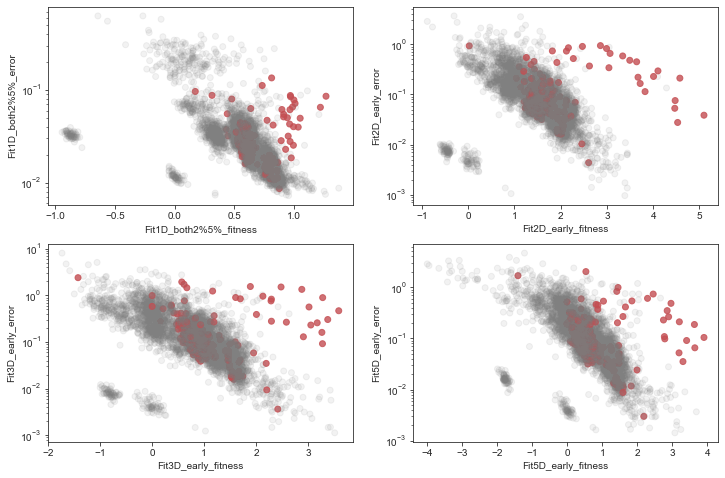

In [50]:
### Are barcodes where evolution condition is unknown too noisy?

plotting_conditions = ['Fit1D_both2%5%','Fit2D_early','Fit3D_early','Fit5D_early']
plt.figure(figsize=(12,8))
for c,condition in enumerate(plotting_conditions):
    plt.subplot(2,2,c+1)
    color_list = [matplotlib.colors.to_rgba('gray',0.1) if evo_cond != 'unknown' else matplotlib.colors.to_rgba('r',0.8)
                  for evo_cond in merged_fitness['evolution_condition'].values]
    
    plt.scatter(merged_fitness[f'{condition}_fitness'],merged_fitness[f'{condition}_error'],c=color_list)
#     plt.scatter(merged_fitness[f'{condition}_fitness'],np.abs(1.96*np.sqrt(merged_fitness[f'{condition}_error'])),c=color_list)
    plt.xlabel(f'{condition}_fitness')
    plt.ylabel(f'{condition}_error')
    
    plt.yscale('log')
    
merged_fitness[merged_fitness['evolution_condition']=='unknown'][['barcode','all_mutations','source_publication','Fit1D-2%-T0','Fit5D-2%-T0']]

In [51]:
#### Remove mutants with unknown evolution condition

merged_fitness = merged_fitness[~merged_fitness['evolution_condition'].isin(['unknown'])]

In [52]:
def z_score_dist(fitness,error,centroid):
    
#     centroid_arr = 
    
    z_score = (fitness-centroid)/np.std(error)
    
    return z_score
    
def cutoff_z_score(fitness,error,centroid,cutoff=2):
    
    z_scores = z_score_dist(fitness,error,centroid)
    
    return [True if np.all(np.abs(z)<cutoff) else False for z in z_scores]
    

Diploid, box: 307
Diploid, 1st cutoff: 330
Diploid, 2nd cutoff: 333
Neutral, box: 323
Neutral, 1st cutoff: 302
Neutral, 2nd cutoff: 303


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


CYR1 96 17 31
Diploid, box: 330
Diploid, 1st cutoff: 327
Diploid, 2nd cutoff: 326
Neutral, box: 1028
Neutral, 1st cutoff: 973
Neutral, 2nd cutoff: 967


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


GPB2 123 0 6
Diploid, box: 487
Diploid, 1st cutoff: 465
Diploid, 2nd cutoff: 465
Neutral, box: 341
Neutral, 1st cutoff: 318
Neutral, 2nd cutoff: 317
TOR1 88 40 20


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Diploid, box: 119
Diploid, 1st cutoff: 119
Diploid, 2nd cutoff: 119
Neutral, box: 98
Neutral, 1st cutoff: 126
Neutral, 2nd cutoff: 127
IRA1_MIS 116 6 0


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Diploid, box: 0
Diploid, 1st cutoff: 0
Diploid, 2nd cutoff: 0
Neutral, box: 0
Neutral, 1st cutoff: 0
Neutral, 2nd cutoff: 0
IRA1_NON 235 6 0


/var/folders/t0/s78ywp_n0sngtydd8db0z3_m0000gn/T/ipykernel_25556/4052647909.py:62: RuntimeWarning: Mean of empty slice
  pure_diploid_centroid = np.nanmean(this_anc[calling_conditions].values[pure_diploids,:],axis=0)
/var/folders/t0/s78ywp_n0sngtydd8db0z3_m0000gn/T/ipykernel_25556/4052647909.py:67: RuntimeWarning: Mean of empty slice
  pure_diploid_centroid = np.nanmean(this_anc[calling_conditions].values[pure_diploids,:],axis=0)
/var/folders/t0/s78ywp_n0sngtydd8db0z3_m0000gn/T/ipykernel_25556/4052647909.py:77: RuntimeWarning: Mean of empty slice
  pure_diploid_centroid = np.nanmean(this_anc[calling_conditions].values[pure_diploids,:],axis=0)
/var/folders/t0/s78ywp_n0sngtydd8db0z3_m0000gn/T/ipykernel_25556/4052647909.py:92: RuntimeWarning: Mean of empty slice
  neutral_haploid_centroid = np.nanmean(this_anc[calling_conditions].values[neutral_haploids,:],axis=0)
/var/folders/t0/s78ywp_n0sngtydd8db0z3_m0000gn/T/ipykernel_25556/4052647909.py:97: RuntimeWarning: Mean of empty slice
  neutr

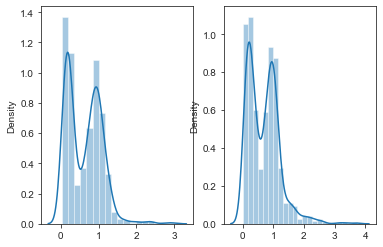

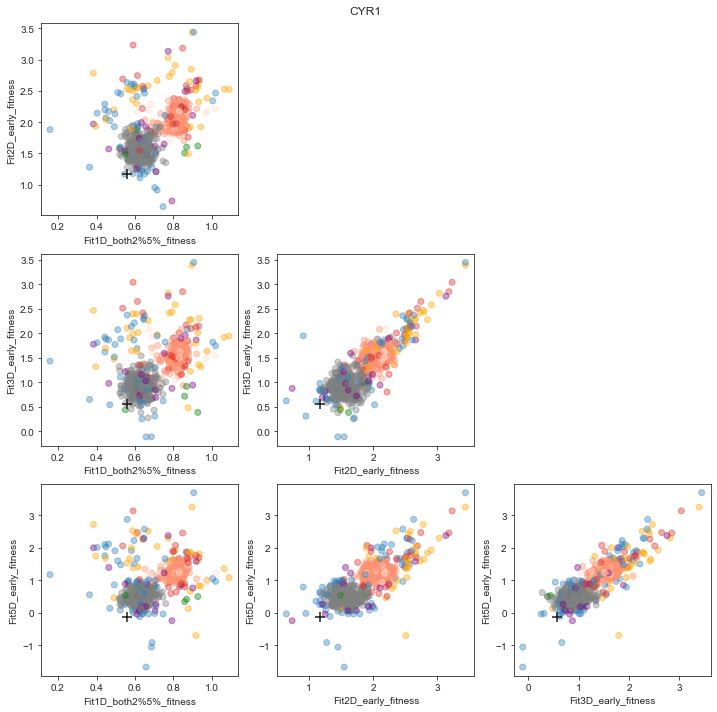

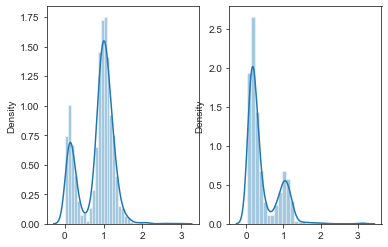

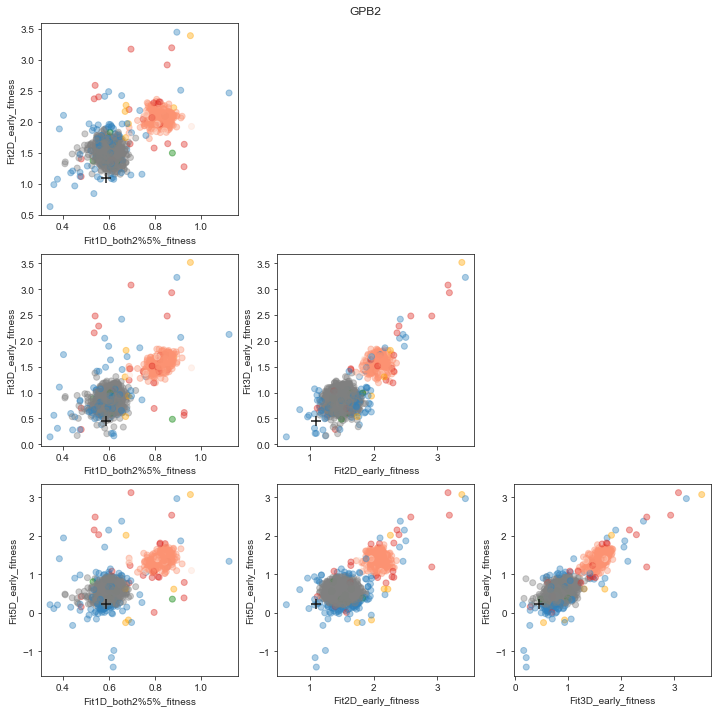

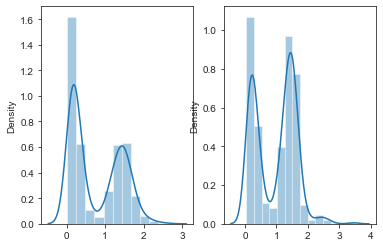

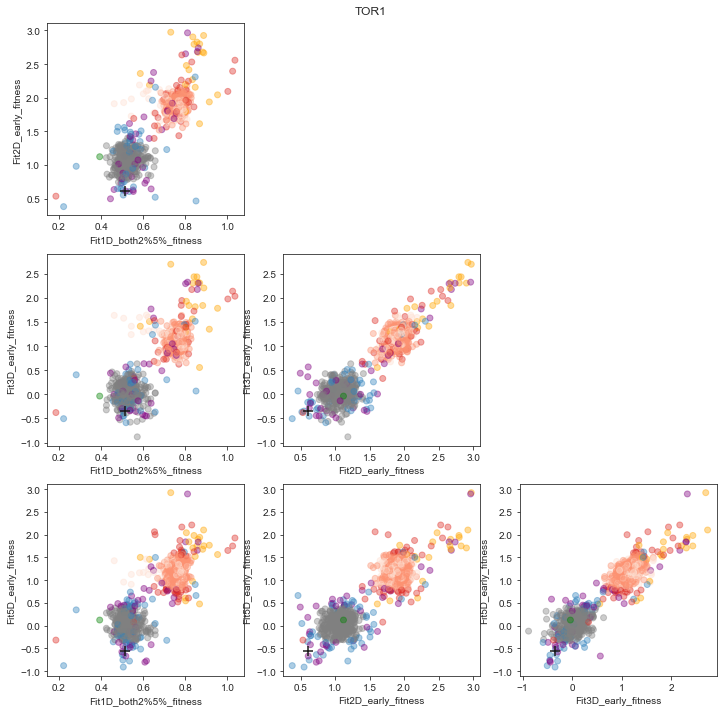

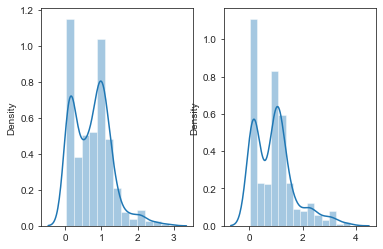

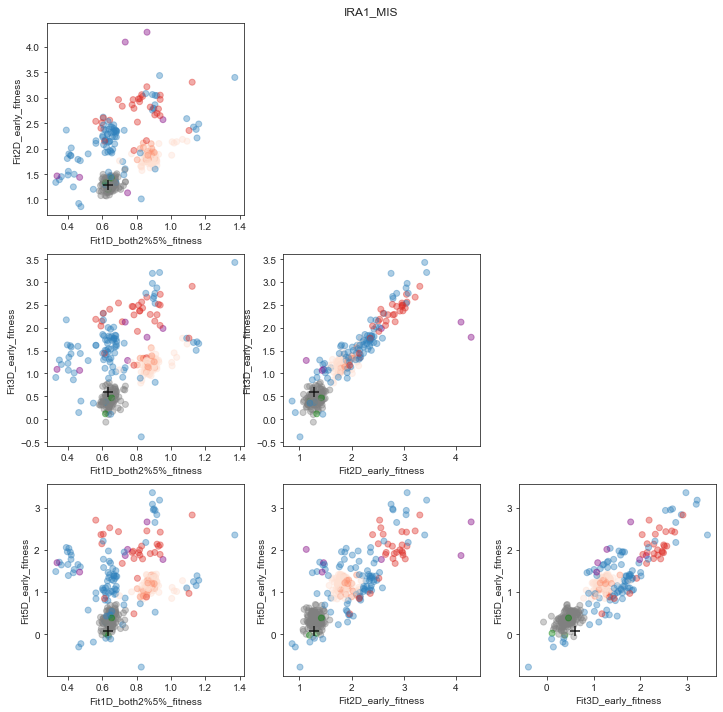

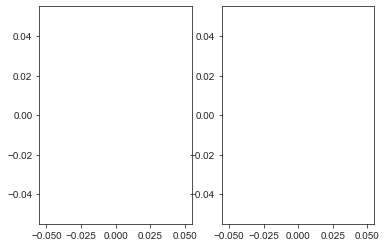

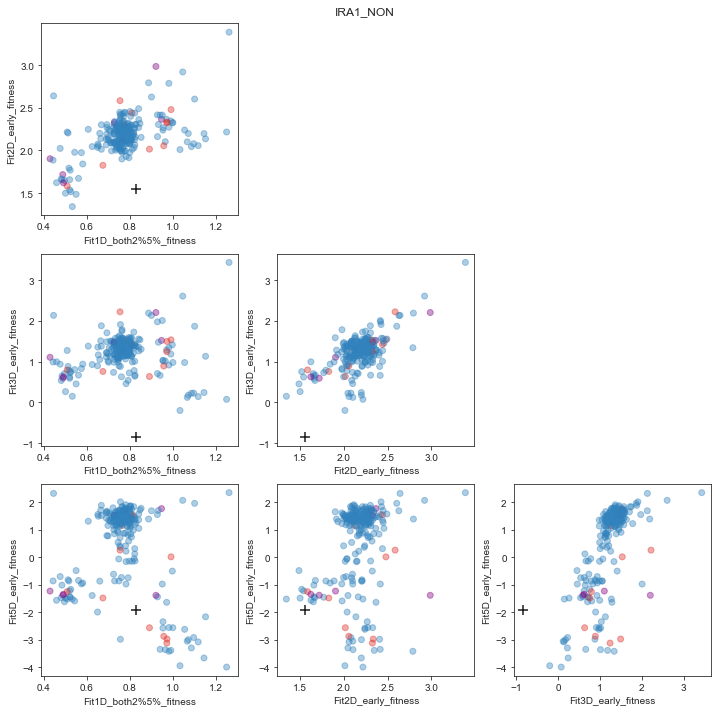

In [56]:
# Calling pure diploids and neutral haploids. According to 1 Day and 2 Day fitness (most accurate atm)
ancestor_list = ['CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON']
ancestor_list = ['CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON']
# ancestor_list = ['CYR1']
# calling_conditions = ['Fit1D_both2%5%_fitness','Fit2D_early_fitness','StaPerHour']

calling_conditions = ['Fit1D_both2%5%_fitness','Fit2D_early_fitness','Fit5D_early_fitness']
calling_errors = [col.replace('fitness','error') for col in calling_conditions]
plotting_conditions = ['Fit1D_both2%5%_fitness','Fit2D_early_fitness','Fit3D_early_fitness','Fit5D_early_fitness']
plotting_errors = [col.replace('fitness','error') for col in plotting_conditions]

haploid_cutoffs = {'CYR1':[(0.5,0.7),(1.0,2.0),(0.0,1.0)],
           'GPB2':[(0.5,0.7),(1.0,2.0),(-0.1,1.1)],
           'TOR1':[(0.4,0.6),(0.3,1.5),(-0.5,0.5)],
           'IRA1_MIS':[(0.5,0.7),(0.75,1.5),(-0.1,0.5)],
           'IRA1_NON':[[0.0,0.0],[0.0,0.0],(0.0,0.0)]}

diploid_cutoffs = {'CYR1':[(0.75,0.9),(1.5,2.5),(1.0,2.0)],
           'GPB2':[[0.72,0.9],[1.5,2.4],(0.5,1.8)],
           'TOR1':[[0.65,0.85],[1.25,2.25],(0.5,1.6)],
           'IRA1_MIS':[[0.75,1.2],[1.4,2.2],(0.8,1.5)],
           'IRA1_NON':[[0.0,0.0],[0.0,0.0],(0.0,0.0)]}

to_sequence = {}
missing_targets = {}
already_sequenced = {}
pure_diploid_dict = {}
neutral_haploid_dict = {}

for a,anc in enumerate(ancestor_list):
    this_anc = merged_fitness[merged_fitness['ancestor']==anc]
#     for evo_cond in np.unique(this_anc['evolution_condition'].values):

    background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]
    
#     diploids = this_anc[this_anc['ploidy_new'].isin(['diploid','Diploid'])]
#     haploids = this_anc[~this_anc['ploidy_new'].isin(['diploid','Diploid'])]
        
#     diploid_avg = np.nanmean(diploids[calling_conditions],axis=0)
#     diploid_25th = np.percentile(diploids[calling_conditions],25,axis=0)
#     diploid_std = np.nanstd(diploids[calling_conditions],axis=0)
    
#     haploid_avg = np.nanmean(haploids[calling_conditions],axis=0)
#     haploid_25th = np.percentile(haploids[calling_conditions],25,axis=0)
#     haploid_std = np.nanstd(haploids[calling_conditions],axis=0)
    
    
    dist_cutoff = 0.4
#     dist_cutoff = 0.5

    pure_diploids = [True if np.all([x > diploid_cutoffs[anc][0][0],
                               x < diploid_cutoffs[anc][0][1],
                               y > diploid_cutoffs[anc][1][0],
                               y < diploid_cutoffs[anc][1][1],
                               z > diploid_cutoffs[anc][2][0],
                               z < diploid_cutoffs[anc][2][1]]) else False
                     for x,y,z in this_anc[calling_conditions].values]
    print('Diploid, box:',sum(pure_diploids))
    
#     pure_diploid_dict[anc] = this_anc['barcode'].values[pure_diploids]
    
    # 2 passes through the ones closest 
    pure_diploid_centroid = np.nanmean(this_anc[calling_conditions].values[pure_diploids,:],axis=0)
    dists = distance.cdist(this_anc[calling_conditions],[pure_diploid_centroid])
    pure_diploids = [True if d<dist_cutoff else False for d in dists ]
    print('Diploid, 1st cutoff:',sum(pure_diploids))
    
    pure_diploid_centroid = np.nanmean(this_anc[calling_conditions].values[pure_diploids,:],axis=0)
    dists = distance.cdist(this_anc[calling_conditions],[pure_diploid_centroid])
    pure_diploids = [True if d<dist_cutoff else False for d in dists ]
    print('Diploid, 2nd cutoff:',sum(pure_diploids))
    
    
#     pure_diploids = cutoff_z_score(this_anc[calling_conditions].values,this_anc[calling_errors].values,pure_diploid_centroid)
    

    pure_diploid_dict[anc] = this_anc['barcode'].values[pure_diploids]
    pure_diploid_centroid = np.nanmean(this_anc[calling_conditions].values[pure_diploids,:],axis=0)
    
    
    
    # first define by the manual boxes
    neutral_haploids = [True if np.all([x > haploid_cutoffs[anc][0][0],
                               x < haploid_cutoffs[anc][0][1],
                               y > haploid_cutoffs[anc][1][0],
                               y < haploid_cutoffs[anc][1][1],
                               z > haploid_cutoffs[anc][2][0],
                               z < haploid_cutoffs[anc][2][1]]) else False
                     for x,y,z in this_anc[calling_conditions].values]
    print('Neutral, box:',sum(neutral_haploids))
        
    # 2 passes through the ones closest 
    neutral_haploid_centroid = np.nanmean(this_anc[calling_conditions].values[neutral_haploids,:],axis=0)
    dists = distance.cdist(this_anc[calling_conditions],[neutral_haploid_centroid])
    neutral_haploids = [True if d<dist_cutoff else False for d in dists ]
    print('Neutral, 1st cutoff:',sum(neutral_haploids))
    
    neutral_haploid_centroid = np.nanmean(this_anc[calling_conditions].values[neutral_haploids,:],axis=0) 
    dists = distance.cdist(this_anc[calling_conditions],[neutral_haploid_centroid])
    neutral_haploids = [True if d<dist_cutoff else False for d in dists ]
    print('Neutral, 2nd cutoff:',sum(neutral_haploids))
    
#     neutral_haploids = cutoff_z_score(this_anc[calling_conditions].values,this_anc[calling_errors].values,neutral_haploid_centroid)

    neutral_haploid_dict[anc] = this_anc['barcode'].values[neutral_haploids]
    neutral_haploid_centroid = np.nanmean(this_anc[calling_conditions].values[neutral_haploids,:],axis=0)
    
    
    plt.figure()
    plt.subplot(1,2,1)
    sns.distplot(distance.cdist(this_anc[calling_conditions],[pure_diploid_centroid]))
    plt.subplot(1,2,2)
    sns.distplot(distance.cdist(this_anc[calling_conditions],[neutral_haploid_centroid]))
    
    
    ploidys = this_anc['ploidy_new'].values
    bcs = this_anc['barcode'].values
    colors = []
    
    to_sequence[anc] = []
    missing_targets[anc] = [] 
    already_sequenced[anc] = []
    for entry in range(len(ploidys)):
        newCloneID = this_anc['cloneID_new'].values[entry]
        gene_from_previous_data = this_anc['additional_muts'].values[entry]

        
        if ploidys[entry] in ['diploid','Diploid']:
            if pure_diploids[entry] == True:
                colors.append('#fc9272') # light red
            elif neutral_haploids[entry] == True:
                colors.append('green')
            else:
                if gene_from_previous_data not in ['NotSequenced',np.nan]:
                    colors.append('orange')
                    already_sequenced[anc].append(bcs[entry])
                elif not p.isnull(newCloneID):
                    colors.append('#de2d26') # dark red
                    to_sequence[anc].append(bcs[entry])
                else:
                    colors.append('purple')
                    missing_targets[anc].append(bcs[entry])
                
                
        else:
            if neutral_haploids[entry] == True:
                colors.append('gray')
            elif pure_diploids[entry] == True:
                colors.append('#fee0d2') # very light red
            else:
                if gene_from_previous_data not in ['NotSequenced',np.nan]:
                    colors.append('orange')
                    already_sequenced[anc].append(bcs[entry])
                elif not p.isnull(newCloneID):
                    colors.append('#3182bd') # dark blue
                    to_sequence[anc].append(bcs[entry])
                else:
                    colors.append('purple')
                    missing_targets[anc].append(bcs[entry])
    
    plt.figure(figsize=(12,12))
    plt.suptitle(anc,y=0.9)       
        
    print(anc,len(to_sequence[anc]),len(missing_targets[anc]),len(already_sequenced[anc]))
    counter = 0
    for c1,c2 in combinations(plotting_conditions,2):
        c1_loc = np.where(np.isin(plotting_conditions,c1))[0][0]
        c2_loc = np.where(np.isin(plotting_conditions,c2))[0][0]
#         print(c1_loc+(c2_loc)*3+1)
        plt.subplot(3,3,c1_loc+(c2_loc-1)*3+1)
        plt.scatter(this_anc[c1],this_anc[c2],color=colors,alpha=0.4)
        plt.xlabel(c1)
        plt.ylabel(c2)
        counter+=1
        plt.scatter(background_mutant[c1].values,background_mutant[c2].values,marker='+',color='k',s=100)

#     plt.savefig(f'plots/WGS_targets_{anc}.pdf',bbox_inches='tight')
    
        
                

In [249]:
np.unique([x for x in merged_fitness[merged_fitness['ancestor']=='CYR1']['class'].values if not p.isnull(x)])

array(['adaptive_haploids', 'high_fitness_diploids', 'neutral_haploids',
       'pure_diploids'], dtype='<U21')

In [57]:
class_new_list = []
for anc,barcode,old_class,ploidy_new in zip(merged_fitness['ancestor'].values,
                                            merged_fitness['barcode'].values,
                                            merged_fitness['class'].values,
                                            merged_fitness['ploidy_new'].values):
    if anc in ['CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON']:
        if barcode in neutral_haploid_dict[anc]:
            class_new_list.append('neutral_haploids')
        elif barcode in pure_diploid_dict[anc]:
            class_new_list.append('pure_diploids')
        else:
            if ploidy_new in (['diploid','Diploid']):
                class_new_list.append('high_fitness_diploids')
            else:
                class_new_list.append('adaptive_haploid')
        
    else:
        class_new_list.append(old_class)
merged_fitness['class_new'] = class_new_list

In [58]:
merged_fitness.to_csv('../2%5%_FitnessMeasurement/data/fitness_withMutations.csv')

In [91]:
# Calling pure diploids and neutral haploids. According to 1 Day and 2 Day fitness (most accurate atm)
ancestor_list = ['CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON']
ancestor_list = ['CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON']
# ancestor_list = ['CYR1']
calling_conditions = ['Fit1D_both2%5%_fitness','Fit2D_early_fitness','StaPerHour']
performance_calls = ['FerPerHour','ResPerHour','StaPerHour']

# calling_conditions = ['Fit1D_both2%5%_fitness','Fit2D_early_fitness','Fit3D_both2%5%_fitness','Fit5D_both2%5%_fitness']
calling_errors = [col.replace('fitness','error') for col in calling_conditions]
plotting_conditions = ['Fit1D_both2%5%_fitness','Fit2D_early_fitness','Fit3D_both2%5%_fitness','Fit5D_both2%5%_fitness']
plotting_errors = [col.replace('fitness','error') for col in plotting_conditions]

haploid_cutoffs = {'CYR1':[(0.5,0.7),(1.0,2.0),(-0.015,0.01)],
           'GPB2':[(0.5,0.7),(1.0,2.0),(-0.01,0.01)],
           'TOR1':[(0.4,0.6),(0.3,1.5),(-0.01,0.01)],
           'IRA1_MIS':[(0.55,0.7),(0.75,1.5),(-0.01,0.01)],
           'IRA1_NON':[[0.0,0.0],[0.0,0.0],(-0.015,0.01)]}

diploid_cutoffs = {'CYR1':[(0.75,0.9),(1.5,2.5),(-0.015,0.01)],
           'GPB2':[[0.72,0.9],[1.5,2.4],(-0.01,0.01)],
           'TOR1':[[0.65,0.8],[1.25,2.25],(-0.01,0.02)],
           'IRA1_MIS':[[0.75,0.9],[1.4,2.2],(0,0.016)],
           'IRA1_NON':[[0.0,0.0],[0.0,0.0],(-0.015,0.01)]}

to_sequence = {}
missing_targets = {}
already_sequenced = {}
pure_diploid_dict = {}
neutral_haploid_dict = {}

for a,anc in enumerate(ancestor_list):
    this_anc = merged_fitness[merged_fitness['ancestor']==anc]
#     for evo_cond in np.unique(this_anc['evolution_condition'].values):

    background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]
    
    diploids = this_anc[this_anc['ploidy_new'].isin(['diploid','Diploid'])]
    haploids = this_anc[~this_anc['ploidy_new'].isin(['diploid','Diploid'])]
        
    diploid_avg = np.nanmean(diploids[calling_conditions],axis=0)
    diploid_25th = np.percentile(diploids[calling_conditions],25,axis=0)
    diploid_std = np.nanstd(diploids[calling_conditions],axis=0)
    
    haploid_avg = np.nanmean(haploids[calling_conditions],axis=0)
    haploid_25th = np.percentile(haploids[calling_conditions],25,axis=0)
    haploid_std = np.nanstd(haploids[calling_conditions],axis=0)


    pure_diploids = [True if np.all([x > diploid_cutoffs[anc][0][0],
                               x < diploid_cutoffs[anc][0][1],
                               y > diploid_cutoffs[anc][1][0],
                               y < diploid_cutoffs[anc][1][1],
                               z > diploid_cutoffs[anc][2][0],
                               z < diploid_cutoffs[anc][2][1]]) else False
                     for x,y,z in this_anc[calling_conditions].values]
    
    pure_diploid_dict[anc] = this_anc['barcode'].values[pure_diploids] 
    
  
    scaler = 2
    

    neutral_haploids = [True if np.all([x > haploid_cutoffs[anc][0][0],
                               x < haploid_cutoffs[anc][0][1],
                               y > haploid_cutoffs[anc][1][0],
                               y < haploid_cutoffs[anc][1][1],
                               z > haploid_cutoffs[anc][2][0],
                               z < haploid_cutoffs[anc][2][1]]) else False
                     for x,y,z in this_anc[calling_conditions].values]
    
    neutral_haploid_dict[anc] = this_anc['barcode'].values[neutral_haploids] 
    

    ploidys = this_anc['ploidy_new'].values
    bcs = this_anc['barcode'].values
    colors = []
    
    to_sequence[anc] = []
    missing_targets[anc] = [] 
    already_sequenced[anc] = []
    for entry in range(len(ploidys)):
        newCloneID = this_anc['cloneID_new'].values[entry]
        gene_from_previous_data = this_anc['additional_muts'].values[entry]
        
        
        
#         if bcs[entry] in KSP1_bcs:
#             colors.append('orange')
#             already_sequenced[anc].append(bcs[entry])
            
#         elif bcs[entry] in real_targets:
#             colors.append('purple')
#             real_targets_here +=1
        
        
        if ploidys[entry] in ['diploid','Diploid']:
            if pure_diploids[entry] == True:
                colors.append('#fc9272') # light red
            elif neutral_haploids[entry] == True:
                colors.append('green')
            else:
                if gene_from_previous_data not in ['NotSequenced',np.nan]:
                    colors.append('orange')
                    already_sequenced[anc].append(bcs[entry])
                elif not p.isnull(newCloneID):
                    colors.append('#de2d26') # dark red
                    to_sequence[anc].append(bcs[entry])
                else:
                    colors.append('purple')
                    missing_targets[anc].append(bcs[entry])
                
                
        else:
            if neutral_haploids[entry] == True:
                colors.append('gray')
            elif pure_diploids[entry] == True:
                colors.append('#fee0d2') # very light red
            else:
                if gene_from_previous_data not in ['NotSequenced',np.nan]:
                    colors.append('orange')
                    already_sequenced[anc].append(bcs[entry])
                elif not p.isnull(newCloneID):
                    colors.append('#3182bd') # dark blue
                    to_sequence[anc].append(bcs[entry])
                else:
                    colors.append('purple')
                    missing_targets[anc].append(bcs[entry])
                
   




In [92]:
wt_map = {'WT':'w',
             'GPB2':'#4daf4a',
             'CYR1':'#e41a1c',
             'TOR1':'#6a51a3',
             'IRA1_MIS':'#02818a',
             'IRA1_NON':'#1f78b4',
            }

marker_map = {'Evo1D':'o',
              'Evo2D':'^',
              'Evo3D':'s',
              'Evo5D':'p',
              'Evo1_5D':'D',
              'unknown':'x',
             }

color_map = {        
             'WT':{'Evo1D':'#cccccc','Evo2D':'#f7f7f7','Evo5D':'#969696','Evo1_5D':'#636363'},
#              'WT':{'Evo1D':'#cccccc','Evo2D':'#252525','Evo5D':'#969696','Evo1_5D':'#636363'},
             'GPB2':{'Evo1D':'#bae4b3','Evo2D':'#74c476','Evo3D':'#238b45','unknown':'#bae4b3'},
             'CYR1':{'Evo1D':'#fcae91','Evo2D':'#fb6a4a','Evo3D':'#cb181d','unknown':'#fcae91'},
             'TOR1':{'Evo1D':'#cbc9e2','Evo2D':'#9e9ac8','Evo3D':'#6a51a3','unknown':'#cbc9e2'},
             'IRA1_MIS':{'Evo1D':'#bdc9e1','Evo2D':'#67a9cf','Evo3D':'#02818a','unknown':'#bdc9e1'},
             'IRA1_NON':{'Evo1D':'#bdd7e7','Evo2D':'#6baed6','Evo3D':'#2171b5','unknown':'#bdd7e7'}
            }

long_colors = list(sns.color_palette())+list(sns.color_palette("Set2"))

long_colors += ['gray']*(len(sorted_all['gene'].values)-len(long_colors))

mutation_color_map = {gene:long_colors[g] for g,gene in enumerate(list(sorted_all['gene'].values)[:20])}


In [93]:
rebarcoding_source_mutants = {
'IRA1_MIS':'CGCTAAAGACATAATGTGGTTTGTTG_CTTCCAACAAAAAATCATTTTTATAC', # BCID 43361 from venkataram 2016
'IRA1_NON':'CGCTAAAGACATAATGTGGTTTGTTG_AGAGTAATCTGCAAGATTCTTTTTCT', # BCID 21967 from venkataram 2016
'CYR1':    'CGCTAAAGACATAATGTGGTTTGTTG_CTCGAAACAGGAAAAGCACTTATCGA', # BCID 43692 from venkataram 2016
'TOR1':    'CGCTAAAGACATAATGTGGTTTGTTG_TAGACAAAATGCAATTGTATTGTCAG' , # BCID 21543 from venkataram 2016
'GPB2':    'CGCTAAAGACATAATGTGGTTTGTTG_TCATGAACGGATAAGCTGGTTGGTTG' , # BCID 7774 from venkataram 2016
}

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explic

double mutant!! ['IRA1:stop_gained:HOM', 'YFL021C-A:upstream_gene_variant:HOM', 'YGR266W:missense_variant:HOM', 'RPL6B:synonymous_variant:HOM', 'STE13:conservative_inframe_deletion:HOM']
double mutant!! ['IRA1:stop_gained:HOM', 'BRR2:missense_variant:HOM', 'YFL021C-A:upstream_gene_variant:HOM', 'ATG1:missense_variant:HOM', 'KSP1:stop_gained:HOM', 'RPL6B:synonymous_variant:HOM', 'KEX2:missense_variant:HOM']
double mutant!! ['IRA1:stop_gained:HOM', 'BRR2:missense_variant:HOM', 'YFL021C-A:upstream_gene_variant:HOM', 'ATG1:missense_variant:HOM', 'KSP1:stop_gained:HOM', 'RPL6B:synonymous_variant:HOM', 'KEX2:missense_variant:HOM']
double mutant!! ['IRA1:stop_gained:HOM', 'BRR2:missense_variant:HOM', 'YFL021C-A:upstream_gene_variant:HOM', 'ATG1:missense_variant:HOM', 'KSP1:stop_gained:HOM', 'RPL6B:synonymous_variant:HOM', 'KEX2:missense_variant:HOM']
double mutant!! ['IRA1:stop_gained:HET', 'MED8:upstream_gene_variant:HET', 'RTG2:missense_variant:HET', 'YHR028W-A:missense_variant:HET', 'YHR02

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


double mutant!! ['IRA1:missense_variant:HOM', 'MIT1:disruptive_inframe_deletion:HET', 'RIF2:missense_variant:HET', 'CIT1:missense_variant:HOM']
double mutant!! ['IRA1:stop_gained:HOM', 'YFL021C-A:upstream_gene_variant:HOM', 'ATG1:missense_variant:HOM', 'KSP1:missense_variant:HOM', 'YIL166C:missense_variant:HOM', 'POL32:upstream_gene_variant:HOM', 'POL32:upstream_gene_variant:HOM', 'GPI13:missense_variant:HOM', 'RPL6B:synonymous_variant:HET', 'KEX2:missense_variant:HOM']
double mutant!! ['IRA1:stop_gained:HOM', 'YFL021C-A:upstream_gene_variant:HOM', 'ATG1:missense_variant:HOM', 'KSP1:missense_variant:HOM', 'YIL166C:missense_variant:HOM', 'POL32:upstream_gene_variant:HOM', 'POL32:upstream_gene_variant:HOM', 'GPI13:missense_variant:HOM', 'RPL6B:synonymous_variant:HET', 'KEX2:missense_variant:HOM']
double mutant!! ['IRA1:stop_gained:HOM', 'YFL021C-A:upstream_gene_variant:HOM', 'ATG1:missense_variant:HOM', 'KSP1:missense_variant:HOM', 'YIL166C:missense_variant:HOM', 'POL32:upstream_gene_var

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


double mutant!! ['IRA1:stop_gained:HOM', 'YFL021C-A:upstream_gene_variant:HOM', 'PUF3:frameshift_variant:HOM', 'RPL6B:synonymous_variant:HOM', 'ELA1:synonymous_variant:HOM', 'SPP2:missense_variant:HOM', 'PUF2:conservative_inframe_insertion:HOM']
double mutant!! ['IRA1:stop_gained:HOM', 'YFL021C-A:upstream_gene_variant:HOM', 'PUF3:frameshift_variant:HOM', 'RPL6B:synonymous_variant:HOM', 'ELA1:synonymous_variant:HOM', 'SPP2:missense_variant:HOM', 'PUF2:conservative_inframe_insertion:HOM']


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


double mutant!! ['IRA1:stop_gained:HOM', 'YFL021C-A:upstream_gene_variant:HOM', 'YGR266W:missense_variant:HOM', 'RPL6B:synonymous_variant:HOM']
double mutant!! ['IRA1:stop_gained:HOM', 'PAB1:missense_variant:HOM', 'YFL021C-A:upstream_gene_variant:HOM', 'RPL6B:synonymous_variant:HOM', 'SPP2:missense_variant:HOM']
double mutant!! ['IRA1:stop_gained:HOM', 'PAB1:missense_variant:HOM', 'YFL021C-A:upstream_gene_variant:HOM', 'RPL6B:synonymous_variant:HOM', 'SPP2:missense_variant:HOM']
double mutant!! ['IRA1:stop_gained:HOM', 'YFL021C-A:upstream_gene_variant:HOM', 'RPL6B:synonymous_variant:HOM', 'SPP2:missense_variant:HOM']
double mutant!! ['IRA1:missense_variant:HOM', 'ENP1:synonymous_variant:HOM', 'MIT1:disruptive_inframe_insertion:HET', 'RTG2:missense_variant:HET']
double mutant!! ['IRA1:missense_variant:HOM', 'TFA1:disruptive_inframe_deletion:HET', 'MKT1:missense_variant:HOM']
double mutant!! ['IRA1:missense_variant:HOM', 'TDA2:upstream_gene_variant:HET', 'PFK1:upstream_gene_variant:HOM',

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explic

double mutant!! ['IRA1:stop_gained:HOM', 'YFL021C-A:upstream_gene_variant:HOM', 'YGR266W:missense_variant:HOM', 'RPL6B:synonymous_variant:HOM', 'STE13:conservative_inframe_deletion:HOM']
double mutant!! ['IRA1:stop_gained:HOM', 'BRR2:missense_variant:HOM', 'YFL021C-A:upstream_gene_variant:HOM', 'ATG1:missense_variant:HOM', 'KSP1:stop_gained:HOM', 'RPL6B:synonymous_variant:HOM', 'KEX2:missense_variant:HOM']
double mutant!! ['IRA1:stop_gained:HOM', 'BRR2:missense_variant:HOM', 'YFL021C-A:upstream_gene_variant:HOM', 'ATG1:missense_variant:HOM', 'KSP1:stop_gained:HOM', 'RPL6B:synonymous_variant:HOM', 'KEX2:missense_variant:HOM']
double mutant!! ['IRA1:stop_gained:HOM', 'BRR2:missense_variant:HOM', 'YFL021C-A:upstream_gene_variant:HOM', 'ATG1:missense_variant:HOM', 'KSP1:stop_gained:HOM', 'RPL6B:synonymous_variant:HOM', 'KEX2:missense_variant:HOM']
double mutant!! ['IRA1:stop_gained:HET', 'MED8:upstream_gene_variant:HET', 'RTG2:missense_variant:HET', 'YHR028W-A:missense_variant:HET', 'YHR02

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


double mutant!! ['IRA1:missense_variant:HOM', 'MIT1:disruptive_inframe_deletion:HET', 'RIF2:missense_variant:HET', 'CIT1:missense_variant:HOM']
double mutant!! ['IRA1:stop_gained:HOM', 'YFL021C-A:upstream_gene_variant:HOM', 'ATG1:missense_variant:HOM', 'KSP1:missense_variant:HOM', 'YIL166C:missense_variant:HOM', 'POL32:upstream_gene_variant:HOM', 'POL32:upstream_gene_variant:HOM', 'GPI13:missense_variant:HOM', 'RPL6B:synonymous_variant:HET', 'KEX2:missense_variant:HOM']
double mutant!! ['IRA1:stop_gained:HOM', 'YFL021C-A:upstream_gene_variant:HOM', 'ATG1:missense_variant:HOM', 'KSP1:missense_variant:HOM', 'YIL166C:missense_variant:HOM', 'POL32:upstream_gene_variant:HOM', 'POL32:upstream_gene_variant:HOM', 'GPI13:missense_variant:HOM', 'RPL6B:synonymous_variant:HET', 'KEX2:missense_variant:HOM']
double mutant!! ['IRA1:stop_gained:HOM', 'YFL021C-A:upstream_gene_variant:HOM', 'ATG1:missense_variant:HOM', 'KSP1:missense_variant:HOM', 'YIL166C:missense_variant:HOM', 'POL32:upstream_gene_var

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


double mutant!! ['IRA1:stop_gained:HOM', 'YFL021C-A:upstream_gene_variant:HOM', 'PUF3:frameshift_variant:HOM', 'RPL6B:synonymous_variant:HOM', 'ELA1:synonymous_variant:HOM', 'SPP2:missense_variant:HOM', 'PUF2:conservative_inframe_insertion:HOM']
double mutant!! ['IRA1:stop_gained:HOM', 'YFL021C-A:upstream_gene_variant:HOM', 'PUF3:frameshift_variant:HOM', 'RPL6B:synonymous_variant:HOM', 'ELA1:synonymous_variant:HOM', 'SPP2:missense_variant:HOM', 'PUF2:conservative_inframe_insertion:HOM']


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


double mutant!! ['IRA1:stop_gained:HOM', 'YFL021C-A:upstream_gene_variant:HOM', 'YGR266W:missense_variant:HOM', 'RPL6B:synonymous_variant:HOM']
double mutant!! ['IRA1:stop_gained:HOM', 'PAB1:missense_variant:HOM', 'YFL021C-A:upstream_gene_variant:HOM', 'RPL6B:synonymous_variant:HOM', 'SPP2:missense_variant:HOM']
double mutant!! ['IRA1:stop_gained:HOM', 'PAB1:missense_variant:HOM', 'YFL021C-A:upstream_gene_variant:HOM', 'RPL6B:synonymous_variant:HOM', 'SPP2:missense_variant:HOM']
double mutant!! ['IRA1:stop_gained:HOM', 'YFL021C-A:upstream_gene_variant:HOM', 'RPL6B:synonymous_variant:HOM', 'SPP2:missense_variant:HOM']
double mutant!! ['IRA1:missense_variant:HOM', 'ENP1:synonymous_variant:HOM', 'MIT1:disruptive_inframe_insertion:HET', 'RTG2:missense_variant:HET']
double mutant!! ['IRA1:missense_variant:HOM', 'TFA1:disruptive_inframe_deletion:HET', 'MKT1:missense_variant:HOM']
double mutant!! ['IRA1:missense_variant:HOM', 'TDA2:upstream_gene_variant:HET', 'PFK1:upstream_gene_variant:HOM',

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


double mutant!! ['IRA1:stop_gained:HOM', 'YFL021C-A:upstream_gene_variant:HOM', 'ATG1:missense_variant:HOM', 'RPL6B:synonymous_variant:HOM', 'KEX2:missense_variant:HOM']
double mutant!! ['IRA1:stop_gained:HOM', 'YFL021C-A:upstream_gene_variant:HOM', 'ATG1:missense_variant:HOM', 'RPL6B:synonymous_variant:HOM', 'KEX2:missense_variant:HOM']
double mutant!! ['IRA1:stop_gained:HOM', 'YFL021C-A:upstream_gene_variant:HOM', 'YGR266W:missense_variant:HOM', 'RPL6B:synonymous_variant:HOM', 'STE13:conservative_inframe_deletion:HOM']
double mutant!! ['IRA1:stop_gained:HOM', 'YFL021C-A:upstream_gene_variant:HOM', 'ATG1:missense_variant:HOM', 'KSP1:stop_gained:HOM', 'RPL6B:synonymous_variant:HOM', 'KEX2:missense_variant:HOM']
double mutant!! ['IRA1:stop_gained:HOM', 'YFL021C-A:upstream_gene_variant:HOM', 'ATG1:missense_variant:HOM', 'KSP1:stop_gained:HOM', 'RPL6B:synonymous_variant:HOM', 'KEX2:missense_variant:HOM']
double mutant!! ['IRA1:stop_gained:HOM', 'YFL021C-A:upstream_gene_variant:HOM', 'ATG1

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explic

double mutant!! ['IRA1:stop_gained:HOM', 'YFL021C-A:upstream_gene_variant:HOM', 'YGR266W:missense_variant:HOM', 'RPL6B:synonymous_variant:HOM', 'STE13:conservative_inframe_deletion:HOM']
double mutant!! ['IRA1:stop_gained:HOM', 'BRR2:missense_variant:HOM', 'YFL021C-A:upstream_gene_variant:HOM', 'ATG1:missense_variant:HOM', 'KSP1:stop_gained:HOM', 'RPL6B:synonymous_variant:HOM', 'KEX2:missense_variant:HOM']
double mutant!! ['IRA1:stop_gained:HOM', 'BRR2:missense_variant:HOM', 'YFL021C-A:upstream_gene_variant:HOM', 'ATG1:missense_variant:HOM', 'KSP1:stop_gained:HOM', 'RPL6B:synonymous_variant:HOM', 'KEX2:missense_variant:HOM']
double mutant!! ['IRA1:stop_gained:HOM', 'BRR2:missense_variant:HOM', 'YFL021C-A:upstream_gene_variant:HOM', 'ATG1:missense_variant:HOM', 'KSP1:stop_gained:HOM', 'RPL6B:synonymous_variant:HOM', 'KEX2:missense_variant:HOM']
double mutant!! ['IRA1:stop_gained:HET', 'MED8:upstream_gene_variant:HET', 'RTG2:missense_variant:HET', 'YHR028W-A:missense_variant:HET', 'YHR02

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


double mutant!! ['IRA1:missense_variant:HOM', 'MIT1:disruptive_inframe_deletion:HET', 'RIF2:missense_variant:HET', 'CIT1:missense_variant:HOM']
double mutant!! ['IRA1:stop_gained:HOM', 'YFL021C-A:upstream_gene_variant:HOM', 'ATG1:missense_variant:HOM', 'KSP1:missense_variant:HOM', 'YIL166C:missense_variant:HOM', 'POL32:upstream_gene_variant:HOM', 'POL32:upstream_gene_variant:HOM', 'GPI13:missense_variant:HOM', 'RPL6B:synonymous_variant:HET', 'KEX2:missense_variant:HOM']
double mutant!! ['IRA1:stop_gained:HOM', 'YFL021C-A:upstream_gene_variant:HOM', 'ATG1:missense_variant:HOM', 'KSP1:missense_variant:HOM', 'YIL166C:missense_variant:HOM', 'POL32:upstream_gene_variant:HOM', 'POL32:upstream_gene_variant:HOM', 'GPI13:missense_variant:HOM', 'RPL6B:synonymous_variant:HET', 'KEX2:missense_variant:HOM']
double mutant!! ['IRA1:stop_gained:HOM', 'YFL021C-A:upstream_gene_variant:HOM', 'ATG1:missense_variant:HOM', 'KSP1:missense_variant:HOM', 'YIL166C:missense_variant:HOM', 'POL32:upstream_gene_var

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


double mutant!! ['IRA1:stop_gained:HOM', 'YFL021C-A:upstream_gene_variant:HOM', 'PUF3:frameshift_variant:HOM', 'RPL6B:synonymous_variant:HOM', 'ELA1:synonymous_variant:HOM', 'SPP2:missense_variant:HOM', 'PUF2:conservative_inframe_insertion:HOM']
double mutant!! ['IRA1:stop_gained:HOM', 'YFL021C-A:upstream_gene_variant:HOM', 'PUF3:frameshift_variant:HOM', 'RPL6B:synonymous_variant:HOM', 'ELA1:synonymous_variant:HOM', 'SPP2:missense_variant:HOM', 'PUF2:conservative_inframe_insertion:HOM']


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


double mutant!! ['IRA1:stop_gained:HOM', 'YFL021C-A:upstream_gene_variant:HOM', 'YGR266W:missense_variant:HOM', 'RPL6B:synonymous_variant:HOM']
double mutant!! ['IRA1:stop_gained:HOM', 'PAB1:missense_variant:HOM', 'YFL021C-A:upstream_gene_variant:HOM', 'RPL6B:synonymous_variant:HOM', 'SPP2:missense_variant:HOM']
double mutant!! ['IRA1:stop_gained:HOM', 'PAB1:missense_variant:HOM', 'YFL021C-A:upstream_gene_variant:HOM', 'RPL6B:synonymous_variant:HOM', 'SPP2:missense_variant:HOM']
double mutant!! ['IRA1:stop_gained:HOM', 'YFL021C-A:upstream_gene_variant:HOM', 'RPL6B:synonymous_variant:HOM', 'SPP2:missense_variant:HOM']
double mutant!! ['IRA1:missense_variant:HOM', 'ENP1:synonymous_variant:HOM', 'MIT1:disruptive_inframe_insertion:HET', 'RTG2:missense_variant:HET']
double mutant!! ['IRA1:missense_variant:HOM', 'TFA1:disruptive_inframe_deletion:HET', 'MKT1:missense_variant:HOM']
double mutant!! ['IRA1:missense_variant:HOM', 'TDA2:upstream_gene_variant:HET', 'PFK1:upstream_gene_variant:HOM',

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


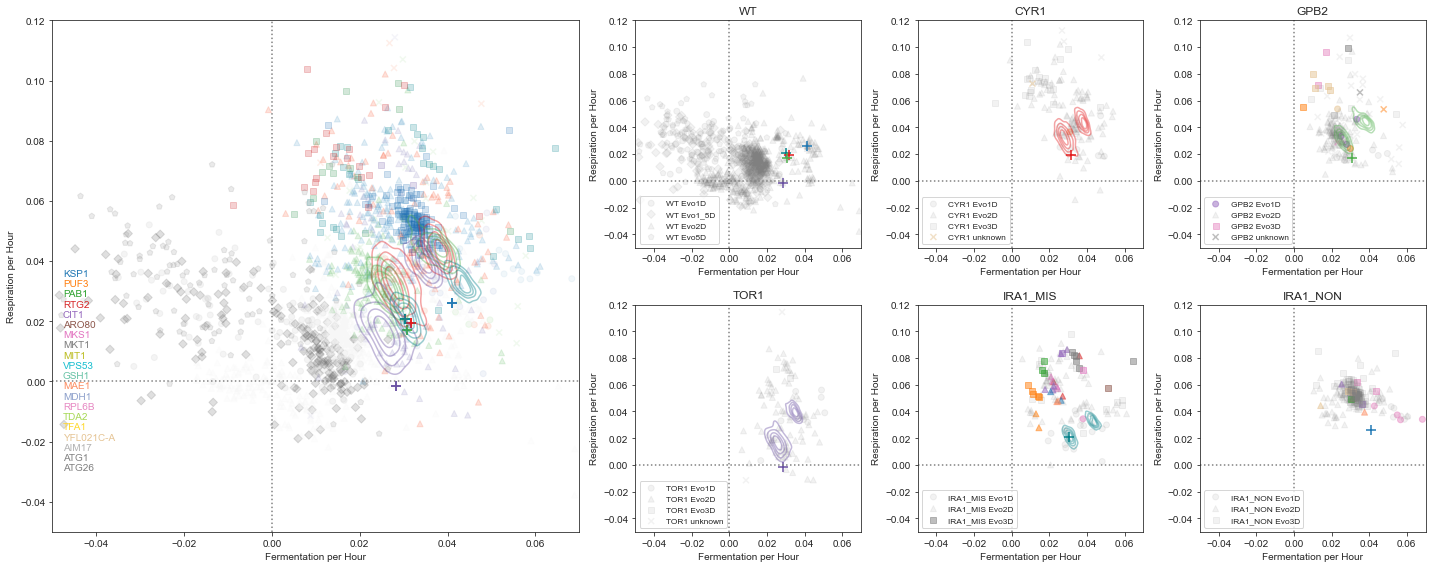

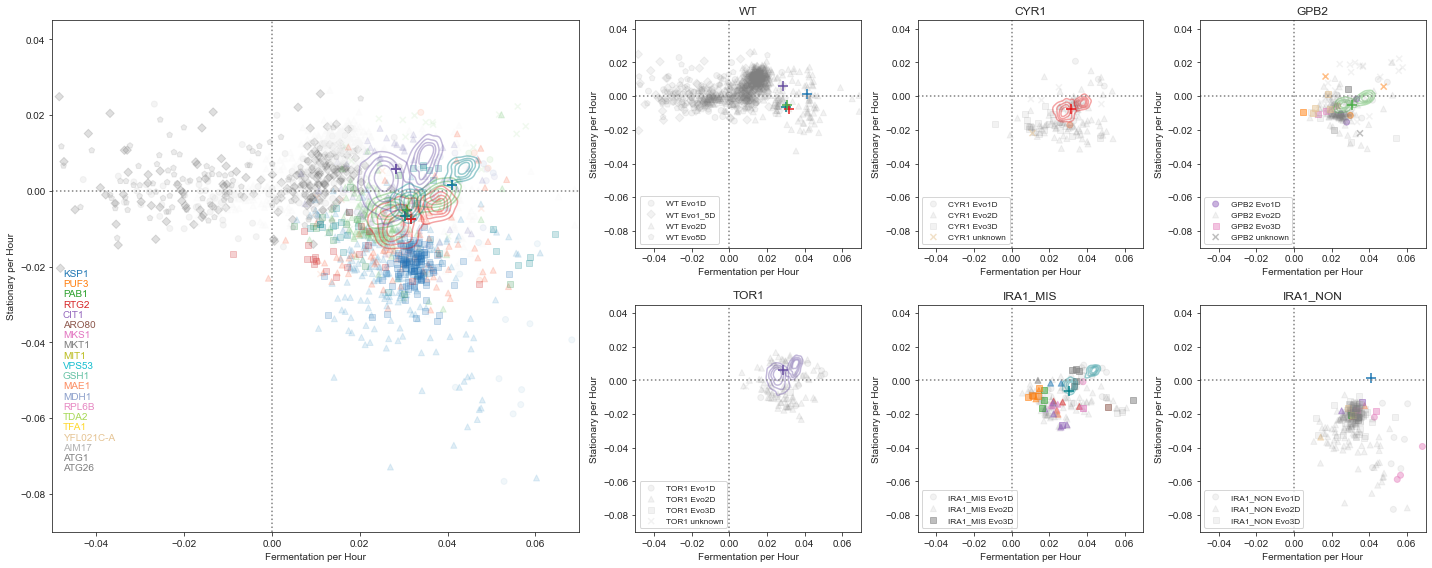

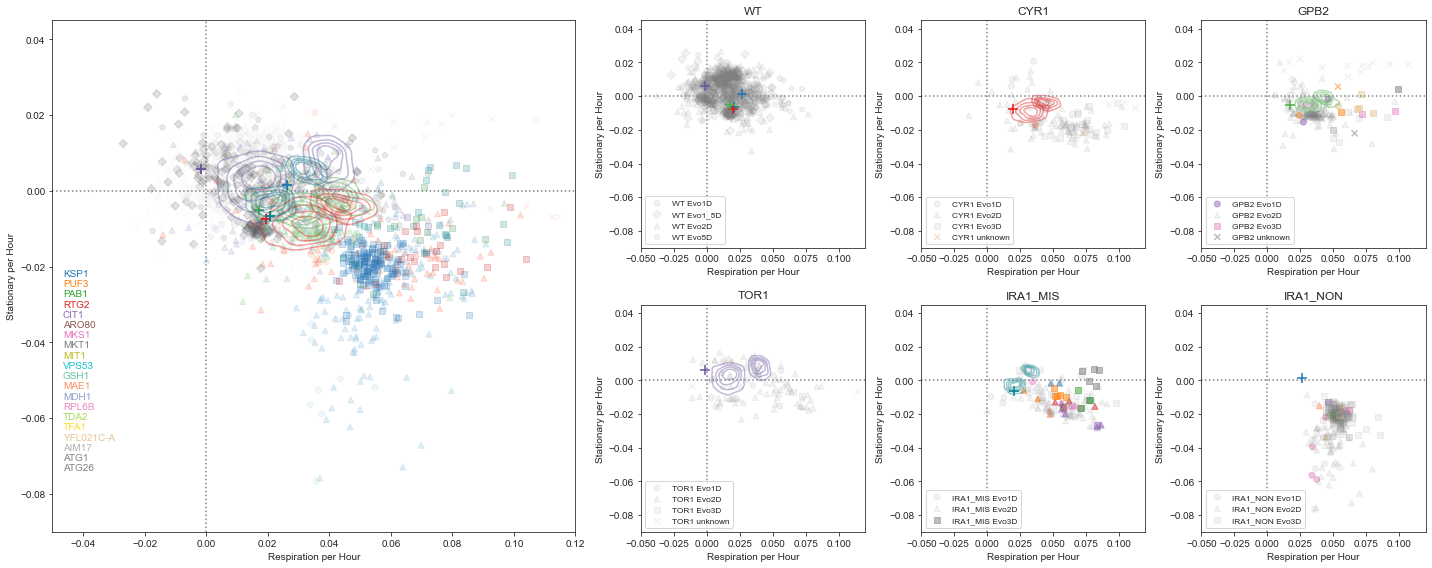

In [94]:


colors = [color_map[anc] for anc in merged_fitness['ancestor']]
# colors = ['b' if source=='This_study' else 'r' if source=='Li2019' else 'orange' if source == 'Aggeli2020' else 'k' for source in nonan_merged['source_publication_x']]

# non_diploid = merged_fitness[merged_fitness['ploidy']!='Diploid']

xlabel = 'Fermentation per Hour'
ylabel = 'Respiration per Hour'
xdata = 'FerPerHour'
ydata = 'ResPerHour'

xlabel = 'Stationary per Hour'
ylabel = 'Respiration per Hour'
xdata = 'StaPerHour'
ydata = 'ResPerHour'
labels = {'FerPerHour':'Fermentation per Hour','ResPerHour':'Respiration per Hour','StaPerHour':'Stationary per Hour'}
lims = {'FerPerHour':[-0.05,0.07],'ResPerHour':[-0.05,0.12],'StaPerHour':[-0.09,0.045]}

# evo_cond_list = ['Evo1D']
# evo_cond_list = ['Evo2D']
# evo_cond_list = ['Evo3D']

for xdata,ydata in combinations(['FerPerHour','ResPerHour','StaPerHour'],2):
# publication_list = [['This_study','Li2019','Aggeli2020','Venkataram2015'],['Venkataram2015'],['Li2019'],['Aggeli2020'],['This_study'],['Venkataram2015','This_study']] 
    ancestor_list = [['WT','CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'],['WT'],['CYR1'],['GPB2'],['TOR1'],['IRA1_MIS'],['IRA1_NON']]
    fig = plt.figure(figsize=(20,8))
    outer_gs = gridspec.GridSpec(1, 2,width_ratios=[2,3])

    for a,ancs in enumerate(ancestor_list):
        inner_gs = gridspec.GridSpecFromSubplotSpec(2,3,subplot_spec = outer_gs[1],wspace=0.25,hspace=0.25)
#         this_anc = non_diploid[non_diploid['ancestor'].isin(ancs)]
        
        this_anc = merged_fitness[merged_fitness['ancestor'].isin(ancs)]
        
        these_pure_diploids = [bc for anc in ancs if anc != 'WT'  for bc in pure_diploid_dict[anc]  ]
        these_neutral_haploids =  [bc for anc in ancs if anc != 'WT'  for bc in neutral_haploid_dict[anc]  ]
        
        interesting_muts = this_anc[~this_anc['barcode'].isin(these_neutral_haploids+these_pure_diploids)]

        if len(ancs) > 1:
            fig.add_subplot(outer_gs[0]) 
        else:
            fig.add_subplot(inner_gs[a-1])
            
        for anc in ancs:
            if anc != 'WT':
                this_pure_diploid = this_anc[this_anc['barcode'].isin(pure_diploid_dict[anc])]

                sns.kdeplot(this_pure_diploid[xdata].values,this_pure_diploid[ydata].values,
                            color=wt_map[anc],alpha=0.4,thresh=0.2,levels=5)

                this_neutral_haploid = this_anc[this_anc['barcode'].isin(neutral_haploid_dict[anc])]

                sns.kdeplot(this_neutral_haploid[xdata].values,this_neutral_haploid[ydata].values,
                            color=wt_map[anc],alpha=0.4,thresh=0.2,levels=5)
#             else:
#                 this_pure_dip


        for evo_cond in np.unique(this_anc['evolution_condition'].values):
#         for evo_cond in evo_cond_list:
            this_data = interesting_muts[interesting_muts['evolution_condition']==evo_cond]
            gray_alpha = 0.1
            bold_alpha = 0.5
            if len(ancs) < 2:
                colors = []
                for entry in this_data['all_mutations'].values:
                    color_assigned = 'gray'
                    already_assigned = False
                    if not p.isnull(entry):
                        if ';' in entry:
                            muts = entry.split(';')
                            for mut in muts:
                                if '-' in mut:
                                    gene_effect = mut.strip(' ').split('-')
                                    if f'{gene_effect}' in preexisting_mutations_genes[anc]:
                                        color_assigned = matplotlib.colors.to_rgba('gray',0.1)
                                    elif '-'.join(gene_effect[:-1]) in mutation_color_map.keys():
                                        if already_assigned != False:
                                            print('double mutant!!',muts)
                                        already_assigned = True
                                        color_assigned = matplotlib.colors.to_rgba(mutation_color_map['-'.join(gene_effect[:-1])],bold_alpha)
                                    else:
                                        color_assigned = matplotlib.colors.to_rgba('gray',0.1)
                                else:
                                    color_assigned = matplotlib.colors.to_rgba('gray',0.1)
                        else:
                            muts = literal_eval(entry)
                            for mut in muts:
                                gene,effect,zyg = mut.split(':')
                                if f'{gene}:{effect}' in preexisting_mutations_genes[anc]:
                                    color_assigned = matplotlib.colors.to_rgba('gray',0.1)
                                elif gene in mutation_color_map.keys():
                                    if already_assigned != False:
                                        print('double mutant!!',muts)
                                    already_assigned = True
                                    color_assigned = matplotlib.colors.to_rgba(mutation_color_map[gene],0.5)
                                else:
                                    color_assigned = matplotlib.colors.to_rgba('gray',0.1)
                    else:
                        color_assigned = matplotlib.colors.to_rgba('gray',0.1)
                    colors.append(color_assigned)
            else:
                colors = [color_map[anc][evo_cond] for anc,evo_cond in zip(this_data['ancestor'],this_data['evolution_condition'])]

            if len(ancs) > 1:
                alpha = 0.2
#                 plt.errorbar(this_data[xdata].values,this_data[ydata].values,
#                             xerr=this_data[xdata+'_error'].values,
#                             yerr=this_data[ydata+'_error'].values,
#                             alpha=alpha,color='k',marker=' ',ls='none')
                plt.scatter(this_data[xdata].values,this_data[ydata].values,
                            alpha=alpha,color=colors,marker=marker_map[evo_cond])
               
                
            else:
                alpha = 0.3
#                 plt.errorbar(this_data[xdata].values,this_data[ydata].values,
#                             xerr=this_data[xdata+'_error'].values,
#                             yerr=this_data[ydata+'_error'].values,
#                             alpha=alpha,color='k',marker=' ',ls='none',label=f'{ancs[0]} {evo_cond}')
#                 plt.scatter(this_data[xdata].values,this_data[ydata].values,
#                             alpha=alpha,color=colors,marker=marker_map[evo_cond],label=f'{ancs[0]} {evo_cond}')
                plt.scatter(this_data[xdata].values,this_data[ydata].values,
                            color=colors,marker=marker_map[evo_cond],label=f'{ancs[0]} {evo_cond}')


               
                plt.legend(loc='lower left',fontsize='small')
                plt.title(f'{ancs[0]}')


#         for anc in ancs:
        for anc in ancs:
            if anc != 'WT':
                background_mutant = merged_fitness[merged_fitness['barcode']==rebarcoding_source_mutants[anc]]
#                 plt.errorbar(background_mutant[xdata].values,background_mutant[ydata].values,
#                             xerr=background_mutant[xdata+'_error'].values,
#                             yerr=background_mutant[ydata+'_error'].values,
#                             marker=' ',color='k',ls='none')
                plt.scatter(background_mutant[xdata].values,background_mutant[ydata].values,
                            marker='+',color=wt_map[anc],s=100)
            else:
                for anc2 in rebarcoding_source_mutants.keys():
                    background_mutant = merged_fitness[merged_fitness['barcode']==rebarcoding_source_mutants[anc2]]

                    plt.scatter(background_mutant[xdata].values,background_mutant[ydata].values,
                            marker='+',color=wt_map[anc2],s=100)


        plt.xlim(lims[xdata][0],lims[xdata][1])
        plt.ylim(lims[ydata][0],lims[ydata][1])

        plt.xlabel(labels[xdata])
        plt.ylabel(labels[ydata])

#         plt.axvline(0,color='k',linestyle=':')
#         plt.axhline(0,color='k',linestyle=':')
        
        plt.axvline(0,color='gray',linestyle=':')
        plt.axhline(0,color='gray',linestyle=':')
        
        if len(ancs) > 1:
            for g,gene in enumerate(mutation_color_map.keys()):
                plt.text(y=0.5-0.02*g,x=0.02,s=f'{gene}',color=mutation_color_map[gene],transform=plt.gca().transAxes)


    plt.tight_layout()
    plt.savefig(f'plots/tradeoffs_{xdata}_{ydata}_mutation_colors.pdf')


In [103]:
mutation_color_map

{'KSP1': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'PUF3': (1.0, 0.4980392156862745, 0.054901960784313725),
 'PAB1': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 'RTG2': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 'CIT1': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 'ARO80': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 'MKS1': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 'MKT1': (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 'MIT1': (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 'VPS53': (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 'GSH1': (0.4, 0.7607843137254902, 0.6470588235294118),
 'MAE1': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 'MDH1': (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 'RPL6B': (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 'TDA2': (0.6509803921568

In [104]:
preexisting_mutations

{'IRA1_NON': ['II:522427:A:T:IRA1:stop_gained:c.4202T>A:p.Leu1401*:1/1',
  'V:510499:G:C:PAB1:missense_variant:c.127G>C:p.Gly43Arg:1/1',
  'VI:101127:T:A:YFL021C-A:upstream_gene_variant:c.-4512A>T:nan:1/1',
  'VII:1023358:C:A:YGR266W:missense_variant:c.703C>A:p.Gln235Lys:1/1',
  'VII:161471:G:C:ATG1:missense_variant:c.1407G>C:p.Leu469Phe:1/1',
  'XII:1029498:C:A:RPL6B:synonymous_variant:c.261C>A:p.Thr87Thr:1/1',
  'XII:123802:AG:AGG:PUF3:frameshift_variant:c.911dupC:p.Tyr305fs:1/1',
  'XIV:204739:G:A:KEX2:missense_variant:c.2312G>A:p.Ser771Asn:1/1',
  'XIV:218512:G:A:ELA1:synonymous_variant:c.151C>T:p.Leu51Leu:1/1',
  'XV:608680:G:T:SPP2:missense_variant:c.518C>A:p.Thr173Lys:1/1'],
 'IRA1_MIS': ['II:522697:G:A:IRA1:missense_variant:c.3932C>T:p.Ala1311Val:1/1',
  'V:142941:CAAT:C:MIT1:disruptive_inframe_deletion:c.1083_1085delTAA:p.Asn362del:0/1',
  'XI:347074:C:T:YKL050C:upstream_gene_variant:c.-1454G>A:nan:1/1',
  'XV:87280:AT:A:MDH2:upstream_gene_variant:c.-4361delA:nan:1/1'],
 'CYR1

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


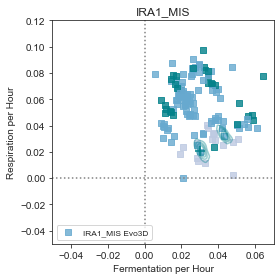

In [97]:


colors = [color_map[anc] for anc in merged_fitness['ancestor']]
# colors = ['b' if source=='This_study' else 'r' if source=='Li2019' else 'orange' if source == 'Aggeli2020' else 'k' for source in nonan_merged['source_publication_x']]

# non_diploid = merged_fitness[merged_fitness['ploidy']!='Diploid']

xlabel = 'Fermentation per Hour'
ylabel = 'Respiration per Hour'
xdata = 'FerPerHour'
ydata = 'ResPerHour'

xlabel = 'Stationary per Hour'
ylabel = 'Respiration per Hour'
xdata = 'StaPerHour'
ydata = 'ResPerHour'
labels = {'FerPerHour':'Fermentation per Hour','ResPerHour':'Respiration per Hour','StaPerHour':'Stationary per Hour'}
lims = {'FerPerHour':[-0.05,0.07],'ResPerHour':[-0.05,0.12],'StaPerHour':[-0.09,0.045]}

# evo_cond_list = ['Evo1D']
# evo_cond_list = ['Evo2D']
# evo_cond_list = ['Evo3D']

# for xdata,ydata in combinations(['FerPerHour','ResPerHour','StaPerHour'],2):
for xdata,ydata in [('FerPerHour','ResPerHour')]:

# publication_list = [['This_study','Li2019','Aggeli2020','Venkataram2015'],['Venkataram2015'],['Li2019'],['Aggeli2020'],['This_study'],['Venkataram2015','This_study']] 
    ancestor_list = [['WT','CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'],['WT'],['CYR1'],['GPB2'],['TOR1'],['IRA1_MIS'],['IRA1_NON']]
    ancestor_list = [['IRA1_NON']]
    ancestor_list = [['IRA1_MIS']]
    fig,ax = plt.subplots(figsize=(4,4))
    
    muts = []
    bcs = []

    for a,ancs in enumerate(ancestor_list):
        
        this_anc = merged_fitness[merged_fitness['ancestor'].isin(ancs)]
        
        these_pure_diploids = [bc for anc in ancs if anc != 'WT'  for bc in pure_diploid_dict[anc]  ]
        these_neutral_haploids =  [bc for anc in ancs if anc != 'WT'  for bc in neutral_haploid_dict[anc]  ]
        
        interesting_muts = this_anc[~this_anc['barcode'].isin(these_neutral_haploids+these_pure_diploids)]
            
        for anc in ancs:
            if anc != 'WT':
                this_pure_diploid = this_anc[this_anc['barcode'].isin(pure_diploid_dict[anc])]

                sns.kdeplot(this_pure_diploid[xdata].values,this_pure_diploid[ydata].values,
                            color=wt_map[anc],alpha=0.4,thresh=0.2,levels=5)

                this_neutral_haploid = this_anc[this_anc['barcode'].isin(neutral_haploid_dict[anc])]

                sns.kdeplot(this_neutral_haploid[xdata].values,this_neutral_haploid[ydata].values,
                            color=wt_map[anc],alpha=0.4,thresh=0.2,levels=5)

#         for evo_cond in np.unique(this_anc['evolution_condition'].values):
#         for evo_cond in evo_cond_list:
        this_data = interesting_muts

        colors = [color_map[anc][evo_cond] for anc,evo_cond in zip(this_data['ancestor'],this_data['evolution_condition'])]

        alpha = 0.8
        sc = plt.scatter(this_data[xdata].values,this_data[ydata].values,
                    alpha=alpha,color=colors,marker=marker_map[evo_cond],label=f'{ancs[0]} {evo_cond}')


        plt.legend(loc='lower left',fontsize='small')
        plt.title(f'{ancs[0]}')

        muts += list(this_data['all_mutations'].values)
        bcs += list(this_data['barcode'].values)
#         for anc in ancs:
        for anc in ancs:
            if anc != 'WT':
                background_mutant = merged_fitness[merged_fitness['barcode']==rebarcoding_source_mutants[anc]]
                plt.scatter(background_mutant[xdata].values,background_mutant[ydata].values,
                            marker='+',color=wt_map[anc],s=100)
            else:
                for anc2 in rebarcoding_source_mutants.keys():
                    background_mutant = merged_fitness[merged_fitness['barcode']==rebarcoding_source_mutants[anc2]]

                    plt.scatter(background_mutant[xdata].values,background_mutant[ydata].values,
                            marker='+',color=wt_map[anc2],s=100)


        plt.xlim(lims[xdata][0],lims[xdata][1])
        plt.ylim(lims[ydata][0],lims[ydata][1])

        plt.xlabel(labels[xdata])
        plt.ylabel(labels[ydata])

#         plt.axvline(0,color='k',linestyle=':')
#         plt.axhline(0,color='k',linestyle=':')
        
        plt.axvline(0,color='gray',linestyle=':')
        plt.axhline(0,color='gray',linestyle=':')
        
        annot = ax.annotate("", xy=(0,0), xytext=(-0.1,-0.1),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
        annot.set_visible(False)
    
        def update_annot(ind):
            pos = sc.get_offsets()[ind["ind"][0]]
            annot.xy = pos
#             text = "{}, {}".format(" ".join([bcs[n] for n in ind["ind"]]), 
#                                    " ".join([muts[n] for n in ind["ind"]]))
            text = "{}".format(" ".join([muts[n] for n in ind["ind"]]))
            annot.set_text(text)
            annot.get_bbox_patch().set_facecolor(cmap(norm(c[ind["ind"][0]])))
            annot.get_bbox_patch().set_alpha(0.4)
            annot.set_wrap(True)


        def hover(event):
            vis = annot.get_visible()
            if event.inaxes == ax:
                cont, ind = sc.contains(event)
                if cont:
                    update_annot(ind)
                    annot.set_visible(True)
                    fig.canvas.draw_idle()
                else:
                    if vis:
                        annot.set_visible(False)
                        fig.canvas.draw_idle()


    plt.tight_layout()
    


    fig.canvas.mpl_connect("motion_notify_event", hover)

    plt.show()







In [135]:
[(x,y) for (x,y) in zip(sc.get_offsets(),muts)]

[(masked_array(data=[0.02546080441639464, 0.08079055051219637],
               mask=[False, False],
         fill_value=1e+20),
  nan),
 (masked_array(data=[0.03627535774005727, 0.07885746788266718],
               mask=[False, False],
         fill_value=1e+20),
  "['IRA1:missense_variant:HOM', 'MKT1:missense_variant:HOM']"),
 (masked_array(data=[0.06375455592790845, 0.08430588314130626],
               mask=[False, False],
         fill_value=1e+20),
  "['MMS4:synonymous_variant:HOM', 'IRA1:stop_gained:HOM', 'IRA1:missense_variant:HOM', 'SPB1:missense_variant:HOM', 'MKT1:missense_variant:None']"),
 (masked_array(data=[0.035928220420325355, 0.08085608064075962],
               mask=[False, False],
         fill_value=1e+20),
  "['SEO1:upstream_gene_variant:HOM', 'IRA1:missense_variant:HOM', 'YIL177W-A:upstream_gene_variant:HET', 'COS5:upstream_gene_variant:HOM', 'MKT1:missense_variant:None', 'ASE1:upstream_gene_variant:HOM']"),
 (masked_array(data=[0.03398780130420977, 0.0875047413116

<IPython.core.display.Javascript object>


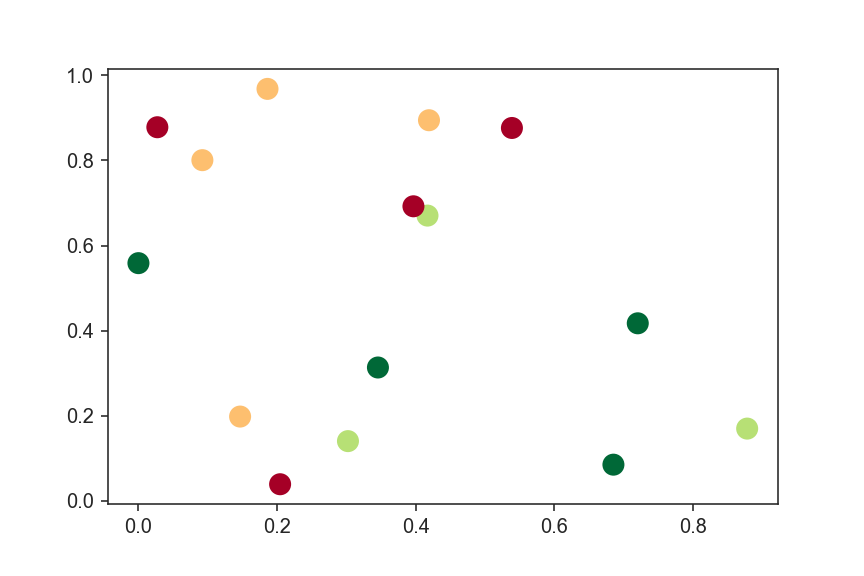

In [124]:
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(1)

x = np.random.rand(15)
y = np.random.rand(15)
names = np.array(list("ABCDEFGHIJKLMNO"))
c = np.random.randint(1,5,size=15)

norm = plt.Normalize(1,4)
cmap = plt.cm.RdYlGn

fig,ax = plt.subplots()
sc = plt.scatter(x,y,c=c, s=100, cmap=cmap, norm=norm)

annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)

def update_annot(ind):

    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = "{}, {}".format(" ".join(list(map(str,ind["ind"]))), 
                           " ".join([names[n] for n in ind["ind"]]))
    annot.set_text(text)
    annot.get_bbox_patch().set_facecolor(cmap(norm(c[ind["ind"][0]])))
    annot.get_bbox_patch().set_alpha(0.4)


def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()

fig.canvas.mpl_connect("motion_notify_event", hover)

plt.show()

In [ ]:
ancestor_list = [['WT'],['CYR1'],['GPB2'],['TOR1'],['IRA1_MIS'],['IRA1_NON']]

mutation_dictionary

for a,ancs in enumerate(ancestor_list):

    this_anc = merged_fitness[merged_fitness['ancestor'].isin(ancs)]

    these_pure_diploids = [bc for anc in ancs if anc != 'WT'  for bc in pure_diploid_dict[anc]  ]
    these_neutral_haploids =  [bc for anc in ancs if anc != 'WT'  for bc in neutral_haploid_dict[anc]  ]

    interesting_muts = this_anc[~this_anc['barcode'].isin(these_neutral_haploids+these_pure_diploids)]

    for evo_cond in np.unique(this_anc['evolution_condition'].values):
#         for evo_cond in evo_cond_list:
        this_data = interesting_muts[interesting_muts['evolution_condition']==evo_cond]
        for entry in this_data['all_mutations'].values:
            if not p.isnull(entry):
                if ';' in entry:
                    muts = entry.split(';')
                    for mut in muts:
                        this_mut_not_pre = []
                        if '-' in mut:
                            gene_effect = mut.strip(' ').split('-')
                            if f'{gene_effect}' in preexisting_mutations_genes[anc]:
                                print(f'{gene_effect} (pre-existing)')
                            else:
                                
                                
                                
                            elif '-'.join(gene_effect[:-1]) in mutation_color_map.keys():
                                if already_assigned != False:
                                    print('double mutant!!',muts)
                                already_assigned = True
                                ['-'.join(gene_effect[:-1])]